# 1 Introduction
### Project Title
**Understanding the Influence of Precipitation, Temperature, and Fuel Moisture Content on the 2019 Gippsland Bushfire**

<div style="background-color:#D3D3D3;padding:15px;border-left:6px solid #A0A0A0;margin-bottom:20px;color:#333;">
    <h3>Topic</h3>
    <p>This project focuses on analyzing the natural factors that influenced the 2019 bushfire in Gippsland, Victoria. Specifically, it examines the roles of precipitation patterns, temperature fluctuations, and fuel moisture content in the context of bushfire occurrences and intensity.</p >

<h3>Research Questions</h3>
    <ol>
        <li>What were the precipitation patterns leading up to and during the 2019 Gippsland bushfire?</li>
        <li>How did temperature fluctuations correlate with fire occurrence and intensity during the 2019 Gippsland bushfire?</li>
        <li>What was the fuel moisture content in the Gippsland region prior to the 2019 bushfire?</li>
    </ol>

<h3>Scope and Data Sources</h3>
    <p style="margin-right:60px; line-height: 1.5;">
    The scope of this project is geographically focused on the Gippsland region in southeastern Australia, with a temporal focus on the year 2019. The primary data sources include:
    </p >
    <ul>
        <li>Point Data: Weather station data (precipitation and temperature records) from the Bureau of Meteorology (BoM).</li>
        <li>Polygon Data: Administrative boundaries and bushfire occurrence records from Data Vic.</li>
        <li>Raster Data: Landsat 8–9 images from Earth Explorer and SILO Data Drill for Vapour Pressure Deficit data.</li>
    </ul>

<h3>Brief Introduction</h3>
    <p style="margin-right:60px; line-height: 1.5;">
    Bushfires are a common and devastating natural disaster in Australia, particularly in southeastern regions such as Gippsland. Historical records show several notable bushfire events, such as Red Tuesday in 1898, Black Friday in 1939, and Black Saturday in 2009 (Victorian Curriculum and Assessment Authority). The 2019–20 bushfire season was particularly disastrous, burning more than 10.7 million hectares of land, causing significant human and wildlife losses, and severely impacting local people and infrastructure (McDougall, 2020; Niklas, 2022).
    </p >
    <p style="margin-right:60px; line-height: 1.5;">
    Although much research has been conducted on forest fires at the national and state levels, relatively few analyses have been conducted specifically on Gippsland. The project aims to fill this gap by providing empirical insights into fire planning and management through a comprehensive analysis of the natural factors influencing the 2019 Gippsland bushfires, quantifying the impact of precipitation patterns, temperature fluctuations, and fuel moisture on fires.
    </p >
</div>

In [1]:
import numpy as np
import os, math
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.features import rasterize
from scipy.stats import pearsonr
from rasterio.plot import show
from statsmodels.tsa.stattools import ccf
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

**Data cleaning**

In [2]:
## Load maximum daily temperature data
# Set folder path
folder_path = 'data/Data extracts for A4/BoM historical daily maximum temperature data'
location_df = pd.read_csv('data/Data extracts for A4/Gippsland weather station locations.csv')

# Get all files in the folder
files = os.listdir(folder_path)

# Filter out all CSV files
csv_files = [file for file in files if file.endswith('.csv')]

# Initialize an empty list to store each CSV file's data frame
data_frames = []

# Read each CSV file and filter by year, then add to data frame list
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df = df[df['Year'] >= 2015]
    data_frames.append(df)

# Concatenate all data frames
temperature_df = pd.concat(data_frames, ignore_index=True)

# Merge with location data
merged_df = pd.merge(temperature_df, location_df, how='left', left_on='Bureau of Meteorology station number', right_on='Site')

# Drop the duplicate 'Bureau of Meteorology station number' column
merged_df.drop(columns=['Bureau of Meteorology station number'], inplace=True)

# Reorder columns to put 'Site' and 'Name' first
columns_order = ['Site', 'Name'] + [col for col in merged_df.columns if col not in ['Site', 'Name']]
df = merged_df[columns_order]

# Save the merged data frame to a new CSV file
df.to_csv('data/combined_temperature_file.csv', index=False)

print('All CSV files have been successfully merged and saved as combined_temperature_file.csv')


All CSV files have been successfully merged and saved as combined_temperature_file.csv


In [3]:
## Load daily rainfall amount data
folder_path = 'data/Data extracts for A4/BoM historical daily rainfall data'
location_df = pd.read_csv('data/Data extracts for A4/Gippsland weather station locations.csv')

# Get all files in the folder
files = os.listdir(folder_path)

# Filter out all CSV files
csv_files = [file for file in files if file.endswith('.csv')]

# Initialize an empty list to store each CSV file's data frame
data_frames = []

# Read each CSV file, filter by year, and add to data frame list
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df = df[df['Year'] >= 2015]
    data_frames.append(df)

# Concatenate all data frames
rainfall_df = pd.concat(data_frames, ignore_index=True)

# Merge with location data
merged_df = pd.merge(rainfall_df, location_df, how='left', left_on='Bureau of Meteorology station number', right_on='Site')

# Drop the duplicate 'Bureau of Meteorology station number' column
merged_df.drop(columns=['Bureau of Meteorology station number'], inplace=True)

# Reorder columns to put 'Site' and 'Name' first
columns_order = ['Site', 'Name'] + [col for col in merged_df.columns if col not in ['Site', 'Name']]
df = merged_df[columns_order]

# Save the merged data frame to a new CSV file
df.to_csv('data/combined_rainfall_file.csv', index=False)

print('All CSV files have been successfully merged and saved as combined_rainfall_file.csv.')

All CSV files have been successfully merged and saved as combined_rainfall_file.csv.


# 2 EDSA

### 2.1 Mapping the Rainfall 🌨️ and Temperature ☀️ Stations in Gippsland

In [4]:
## Load Gippsland regions boundary
## Source from Vicmap
## Link: https://www.land.vic.gov.au/maps-and-spatial/spatial-data/vicmap-catalogue/vicmap-admin
gippsland_region_pg_path = 'data/ESDA'

files = os.listdir(gippsland_region_pg_path)

# Filter out all polygon folders
polygon_folders = [file for file in files if file.endswith('polygon')]

## Transform GDA 2020 Vicgrid (EPSG 7899) 
## to MAG zone 55 (EPSG 7855) format
out_crs = 7855

## Initialize two empty lists to store each region's name and polygon
region_names = []; region_polygons = []

# Read each shp folder and then append the region name and also its polygon into the list
for name in polygon_folders:
    region_names.append(name.replace('_polygon', ''))
    file_path = os.path.join(gippsland_region_pg_path, name)
    polygon = gpd.read_file(file_path)

    polygon = polygon.drop(columns = ['d_y_n_ID'])
    polygon = polygon.drop(polygon.index.to_list()[1:], axis=0)
    polygon = polygon.to_crs(out_crs)
    region_polygons.append(polygon)
    
Gippsland_region_gdf = gpd.GeoDataFrame(pd.concat(region_polygons, ignore_index=True))
Gippsland_region_gdf.insert(0, 'name', region_names)
print('All regional bounderies have been saved in a geo-dataframe with name Gippsland_region_gdf.')
Gippsland_region_gdf.head(3)
## -----

All regional bounderies have been saved in a geo-dataframe with name Gippsland_region_gdf.


,name,geometry
0,Wellington,"POLYGON ((534068.191 5769500.503, 534053.168 5..."
1,Latrobe,"POLYGON ((464760.573 5759234.140, 464730.718 5..."
2,East_Gippsland,"POLYGON ((647066.123 5814828.038, 646961.948 5..."


In [5]:
## Load rainfall records and extract station informations
## -----
rainfall_record_path = 'data/Data extracts for A4/combined_rainfall_file.csv'

## read the integrated rainfall records
Rainfall_record = pd.read_csv(rainfall_record_path)

## transform lon and lat coordinates (EPSG 4326) to MAG zone 55 (EPSG 7855) format
## and clip these stations outside of Gippsland
out_crs = 7855
pt_geoms = gpd.points_from_xy(x=Rainfall_record.Lon,
			y=Rainfall_record.Lat,
			crs="EPSG:4326")
pt_geoms = pt_geoms.to_crs(out_crs)
Rainfall_record = gpd.GeoDataFrame(Rainfall_record, geometry=pt_geoms).drop(columns = ['Lat', 'Lon'])
Rainfall_record = gpd.clip(Rainfall_record, Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland']).reset_index(drop=True)

## extract their coordinates
Rainfall_station_gdf = Rainfall_record[['Site', 'Name', 'geometry']].drop_duplicates().reset_index(drop=True)
print('20 rainfall stations informations in Gippsland have been saved in geo-dataframe with name Rainfall_station_gdf.')
Rainfall_station_gdf.head(3)

20 rainfall stations informations in Gippsland have been saved in geo-dataframe with name Rainfall_station_gdf.


,Site,Name,geometry
0,85096,WILSONS PROMONTORY LIGHTHOUSE,POINT (450266.025 5668672.706)
1,85301,CORNER INLET (YANAKIE),POINT (429980.747 5704542.521)
2,85099,POUND CREEK,POINT (396480.143 5723643.920)


In [6]:
## Load temperature records and extract station informations
## -----
temperature_record_path = 'data/Data extracts for A4/combined_temperature_file.csv'

## read the integrated rainfall records and extract their coordinates
Temperature_record = pd.read_csv(temperature_record_path)

## transform lon and lat coordinates (EPSG 4326) to MAG zone 55 (EPSG 7855) format
## and clip these stations outside of Gippsland 
out_crs = 7855
pt_geoms = gpd.points_from_xy(x=Temperature_record.Lon,
            y=Temperature_record.Lat,
            crs="EPSG:4326")
pt_geoms = pt_geoms.to_crs(out_crs)
Temperature_record = gpd.GeoDataFrame(Temperature_record, geometry=pt_geoms).drop(columns = ['Lat', 'Lon'])
Temperature_record = gpd.clip(Temperature_record, Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland']).reset_index(drop=True)

## extract their coordinates
Temperature_station_gdf = Temperature_record[['Site', 'Name', 'geometry']].drop_duplicates().reset_index(drop=True)
print('19 temperature stations informations in Gippsland have been saved in geo-dataframe with name Rainfall_station_gdf.')
Temperature_station_gdf.head(3)
## -----

19 temperature stations informations in Gippsland have been saved in geo-dataframe with name Rainfall_station_gdf.


,Site,Name,geometry
0,85096,WILSONS PROMONTORY LIGHTHOUSE,POINT (450266.025 5668672.706)
1,85151,YARRAM AIRPORT,POINT (478037.079 5731497.199)
2,85072,EAST SALE,POINT (511597.332 5781350.529)


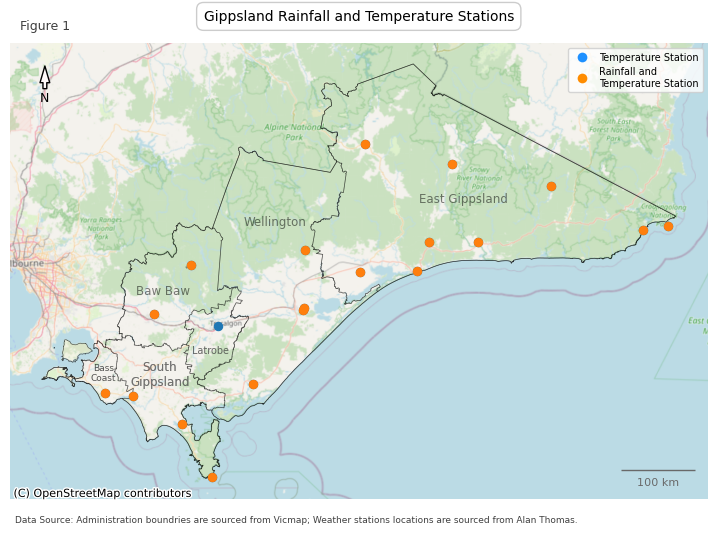

In [7]:
import contextily as cx
from matplotlib.lines import Line2D
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

## Plotting rainfall stations and temperature stations in Gippsland map
## -----
fig, ax = plt.subplots(figsize=(9, 7))
ax.axis('off')

Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].plot(ax = ax, 
                facecolor="none", 
                edgecolor="k", 
                linewidth=0.5, 
                alpha = 0.6)

Gippsland_region_gdf[Gippsland_region_gdf.name != 'Gippsland'].plot(ax=ax, 
                facecolor = 'none', 
                edgecolor='k', 
                linewidth=0.5, 
                alpha=0.4)

Rainfall_station_gdf.plot(ax = ax, 
                linewidth=0.8,
                legend=True)

Temperature_station_gdf.plot(ax = ax, 
                linewidth=0.8,
                legend=True)

## add the title, region name, orientation arrow, scale and data source
ax.annotate(f'Gippsland Rainfall and Temperature Stations', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.5, 1.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='black', boxstyle='round,pad=0.5'))

## add region names
ax.annotate(f'East Gippsland', xy=(0.23, 0.9), xycoords='axes fraction', 
        xytext=(0.65, 0.65), textcoords='axes fraction',
        horizontalalignment='center', fontsize=8.5, color='black', alpha=0.5)

ax.annotate(f'Wellington', xy=(0.23, 0.9), xycoords='axes fraction', 
        xytext=(0.38, 0.6), textcoords='axes fraction',
        horizontalalignment='center', fontsize=8.5, color='black', alpha=0.5)

ax.annotate(f'Latrobe', xy=(0.23, 0.9), xycoords='axes fraction', 
        xytext=(0.287, 0.32), textcoords='axes fraction',
        horizontalalignment='center', fontsize=7, color='dimgray', alpha=0.55)

ax.annotate(f'Latrobe', xy=(0.23, 0.9), xycoords='axes fraction', 
        xytext=(0.287, 0.32), textcoords='axes fraction',
        horizontalalignment='center', fontsize=7, color='black', alpha=0.35)

ax.annotate(f'Baw Baw', xy=(0.23, 0.9), xycoords='axes fraction', 
        xytext=(0.22, 0.45), textcoords='axes fraction',
        horizontalalignment='center', fontsize=8.5, color='black', alpha=0.5)

ax.annotate(f'South\nGippsland', xy=(0.23, 0.9), xycoords='axes fraction', 
        xytext=(0.215, 0.25), textcoords='axes fraction',
        horizontalalignment='center', fontsize=8.5, color='black', alpha=0.5)

ax.annotate(f'South\nGippsland', xy=(0.23, 0.9), xycoords='axes fraction', 
        xytext=(0.215, 0.25), textcoords='axes fraction',
        horizontalalignment='center', fontsize=8.5, color='dimgray', alpha=0.55)

ax.annotate(f'Bass\nCoast', xy=(0.23, 0.9), xycoords='axes fraction', 
        xytext=(0.134, 0.26), textcoords='axes fraction',
        horizontalalignment='center', fontsize=6.5, color='black', alpha=0.65)

# -- Python Citation --
# The following snippet of code aims to add a 'North Arrow'
# And it is impelmented based on a suggestion from Steven in 2019.
# https://stackoverflow.com/questions/58088841/how-to-add-a-north-arrow-on-a-geopandas-map
# ----- ----- ----- ----- -----
x, y, arrow_length = 0.05, 0.95, 0.07
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
        arrowprops=dict(facecolor='snow', width=2.75, headwidth=7),
        ha='center', va='center', fontsize=9,
        xycoords=ax.transAxes)
# ----- ----- ----- ----- -----

fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(ax.transData,
                        50000, '100 km', 'lower right',
                        pad=0.1,
                        borderpad=1,
                        sep=5,
                        color='dimgray',
                        frameon=False,
                        size_vertical=1,
                        fontproperties=fontprops)
ax.add_artist(scalebar)

cx.add_basemap(ax, crs=Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].crs, 
        source = cx.providers.OpenStreetMap.Mapnik,
        alpha = 0.8)

ax.annotate(f'Data Source: Administration boundries are sourced from Vicmap; Weather stations locations are sourced from Alan Thomas.', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.41, -0.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=6.5, color='black', alpha=0.75)

ax.annotate(f'Figure 1', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.05, 1.03), textcoords='axes fraction',
            horizontalalignment='center', fontsize=9, color='black', alpha=0.75)

# -- Python Citation --
# The following snippet of code aims to add a legend
# And it is impelmented based on a suggestion from CreekGeek in 2019.
# https://stackoverflow.com/questions/39500265/how-to-manually-create-a-legend
# ----- ----- ----- ----- -----
# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

# create manual symbols for legend
point1 = Line2D([0], [0], label='Temperature Station', marker='o', markersize=7, 
        markerfacecolor='dodgerblue', alpha=1, linestyle='', markeredgewidth=0)
point2 = Line2D([0], [0], label='Rainfall and\nTemperature Station', marker='o', markersize=7, 
        markerfacecolor='darkorange', linestyle='', markeredgewidth=0)

# add manual symbols to auto legend
handles.extend([point1, point2])
ax.legend(handles=handles, loc='best', prop={'size': 7})
# ----- ----- ----- ----- -----

plt.show()
## -----


<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333">
    <h4 style="color:#007BFF;">Weather Stations Overview 1</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        Most of the meteorological monitoring stations in Gippsland are capable of measuring both rainfall and temperature. Among these, there are 20 stations for rainfall and 19 stations for temperature. From the map (Figure 1), it appears that the station in Latrobe is only capable of measuring temperature. 
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        East Gippsland, being the largest area in Gippsland, hosts nearly half of the meteorological stations. The predominant economic activity in this region is agriculture, and farmers require timely meteorological information to support crop production. Additionally, East Gippsland is frequently affected by bushfires during the fire season, so having more meteorological stations aids in establishing disaster warnings.
    </p>
</div>

### 2.2 Point Pattern Analysis

In [8]:
import pointpats
from pointpats import PointPattern

#### 2.2.1 Average Nearest Neighbour Distance

In [9]:
## Calculate mean nearest distance
# -----
def coord_array(point_data):
    ## Creating an array of coordinates
    coordinates = list()
    for index, row in point_data.iterrows():
        coordinates.append((row.geometry.x, row.geometry.y))
    coordinate_array = np.array(coordinates)

    return coordinate_array


## Calculating the average nearest neighbour distance across rainfall stations and temperature stations
Rainfall_station_pattern = PointPattern(coord_array(Rainfall_station_gdf))
print("Mean nearest rainfall station distance: {} km".format(round(Rainfall_station_pattern.mean_nnd / 1000, 2)))

Temperature_station_pattern = PointPattern(coord_array(Temperature_station_gdf))
print("Mean nearest temperature station distance: {} km".format(round(Temperature_station_pattern.mean_nnd / 1000, 2)))
## -----

Mean nearest rainfall station distance: 32.88 km
Mean nearest temperature station distance: 32.79 km


#### 2.2.2 Ripley's L Function

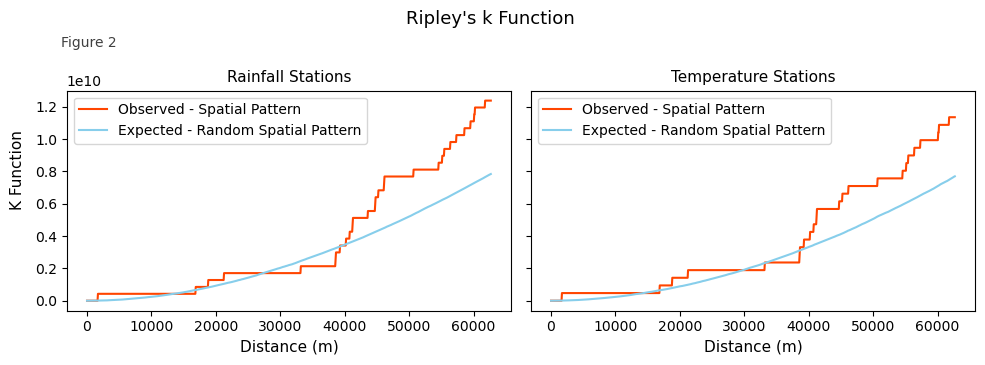

In [10]:
## -----
## Plotting Ripley's k Function in rainfall stations and temperature stations

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey = True)
fig.suptitle('Ripley\'s k Function', fontsize = 13, y = 0.9)
fig.supylabel("K Function", fontsize = 11)

## Calculating Rainfall stations' k function
Rainfall_k_point_pattern = pointpats.k_test(coord_array(Rainfall_station_gdf), support = 1000, keep_simulations = True, n_simulations = 999)

## Calculating Temperature stations' k function
Temperature_k_point_pattern = pointpats.k_test(coord_array(Temperature_station_gdf), support = 1000, keep_simulations = True, n_simulations = 999)


## plotting Rainfall stations' k function
axs[0].plot(Rainfall_k_point_pattern.support, Rainfall_k_point_pattern.statistic, 
         color='orangered', label='Observed - Spatial Pattern')
## plotting the mean of simulations of Rainfall stations' pattern
axs[0].plot(Rainfall_k_point_pattern.support, np.mean(Rainfall_k_point_pattern.simulations, axis=0), 
         color='skyblue', label = 'Expected - Random Spatial Pattern')
axs[0].legend()
axs[0].set_title("Rainfall Stations", fontsize = 11)
axs[0].set_xlabel("Distance (m)", fontsize = 11)

## plotting Temperature stations' L function
axs[1].plot(Temperature_k_point_pattern.support, Temperature_k_point_pattern.statistic, 
         color='orangered', label='Observed - Spatial Pattern')
## plotting the mean of simulations of Temperature stations' pattern
axs[1].plot(Temperature_k_point_pattern.support, np.mean(Temperature_k_point_pattern.simulations, axis=0), 
         color='skyblue', label = 'Expected - Random Spatial Pattern')
axs[1].legend()
axs[1].set_title("Temperature Stations", fontsize = 11)
axs[1].set_xlabel("Distance (m)", fontsize = 11)


axs[0].annotate(f'Figure 2', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.05, 1.2), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

fig.tight_layout()
## -----

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Weather Stations Overview 2</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        Based on the calculation results of the mean nearest distance (MND), the average distance between rainfall stations in Gippsland is 32.88 km, and for temperature stations, it is 32.79 km. This indicates that, on average, there is a meteorological monitoring station approximately every 40 kilometers in Gippsland.
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        Additionally, observing the results from Ripley's K function (Figure 2), it can be seen that a tendency for stations to be grouped together in clusters instead of randomly distributed when considering distances over 40 kilometers.
    </p>
</div>

### 2.3 Areal Data Analysis

#### 2.3.1 Spatial Autocorrelation

In [11]:
## Calculuting the overall weather conditions in 2019 in Gippsland
## -----
## Calculuting the total rainfall amount in 2019 in every Gippsland stations
Rainfall_record_2019_annual = Rainfall_record[Rainfall_record.Year == 2019].groupby(['Site', 'Name', 'Year','geometry'], as_index=False)['Rainfall amount (millimetres)'].sum()
Rainfall_record_2019_annual = gpd.GeoDataFrame(Rainfall_record_2019_annual, geometry=Rainfall_record_2019_annual.geometry)

## Calculating the average daily maximum temperature in 2019 in every Gippsland stations
Temperature_record_2019_annual = Temperature_record[Temperature_record.Year == 2019].groupby(['Site', 'Name', 'Year','geometry'], as_index=False)['Maximum temperature (Degree C)'].mean()
Temperature_record_2019_annual = gpd.GeoDataFrame(Temperature_record_2019_annual, geometry=Temperature_record_2019_annual.geometry)

print('The overall rainfall and temperature in 2019 in every Gippsland stations have been calculated.')
## -----

The overall rainfall and temperature in 2019 in every Gippsland stations have been calculated.


Text(0.1, 1.1, 'Figure 3')

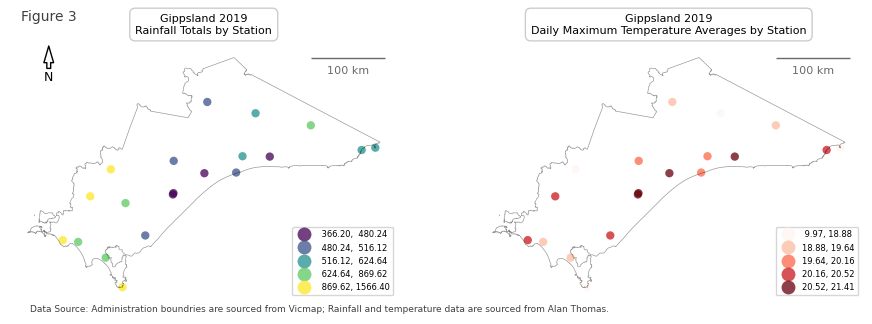

In [12]:

## Plotting the total rainfall amount and the average daily maximum temperature in 2019 in every Gippsland stations
## -----
fig, axs = plt.subplots(1, 2, figsize=(11, 4.5), sharey = True)

Rainfall_record_2019_annual.plot(
    column="Rainfall amount (millimetres)",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 1,
                "fontsize": "6",
                "loc": "lower right"},
    ax=axs[0],
)

Temperature_record_2019_annual.plot(
    column="Maximum temperature (Degree C)",
    cmap="Reds",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 1,
                "fontsize": "6",
                "loc": "lower right"},
    ax=axs[1],
)

axs[0].annotate(f'Gippsland 2019\nRainfall Totals by Station', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.5, 1.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=8, color='black',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='black', boxstyle='round,pad=0.5'))

axs[1].annotate(f'Gippsland 2019\nDaily Maximum Temperature Averages by Station', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.5, 1.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=8, color='black',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='black', boxstyle='round,pad=0.5'))

Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].plot(ax = axs[0], 
                facecolor="none", 
                edgecolor="k", 
                linewidth=0.5, 
                alpha = 0.4)

Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].plot(ax = axs[1], 
                facecolor="none", 
                edgecolor="k", 
                linewidth=0.5, 
                alpha = 0.4)

axs[0].annotate(f'Data Source: Administration boundries are sourced from Vicmap; Rainfall and temperature data are sourced from Alan Thomas.', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.8, -0.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=6.5, color='black', alpha=0.75)

# -- Python Citation 1 --
# The following snippet of code aims to add a 'North Arrow'
# And it is impelmented based on a suggestion from Steven in 2019.
# https://stackoverflow.com/questions/58088841/how-to-add-a-north-arrow-on-a-geopandas-map
# ----- ----- ----- ----- -----
x, y, arrow_length = 0.1, 1, 0.125
axs[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
        arrowprops=dict(facecolor='snow', width=2.75, headwidth=7),
        ha='center', va='center', fontsize=9,
        xycoords=axs[0].transAxes)
# ----- ----- ----- ----- -----

## scale ruler
fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(ax.transData,
                        50000, '100 km', 'upper right',
                        pad=0.1,
                        borderpad=1,
                        sep=5,
                        color='dimgray',
                        frameon=False,
                        size_vertical=1,
                        fontproperties=fontprops)
axs[0].add_artist(scalebar)

fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(ax.transData,
                        50000, '100 km', 'upper right',
                        pad=0.1,
                        borderpad=1,
                        sep=5,
                        color='dimgray',
                        frameon=False,
                        size_vertical=1,
                        fontproperties=fontprops)
axs[1].add_artist(scalebar)

axs[0].set_axis_off()
axs[1].set_axis_off()

axs[0].annotate(f'Figure 3', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.1, 1.1), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

## -----

In [13]:
## -----
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import plot_moran

## Calculating Moran's I

## Generating weight matrix (w) from the rainfall dataframe
Rainfall_w = weights.KNN.from_dataframe(Rainfall_record_2019_annual, k = 5)
## Calculting the Moran's I score in rainfall stations
Rainfall_moran = esda.moran.Moran(Rainfall_record_2019_annual['Rainfall amount (millimetres)'], Rainfall_w)
print("The value of Moran's I in Gippsland Rainfall Stations: {}".format(round(Rainfall_moran.I, 2)))

## Generating weight matrix (w) from the temperature dataframe
Temperature_w = weights.KNN.from_dataframe(Temperature_record_2019_annual, k = 5)
## Calculting the Moran's I score in temperature stations
Temperature_moran = esda.moran.Moran(Temperature_record_2019_annual['Maximum temperature (Degree C)'], Temperature_w)
print("The value of Moran's I in Gippsland Temperature Stations: {}".format(round(Temperature_moran.I, 2)))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The value of Moran's I in Gippsland Rainfall Stations: 0.27
The value of Moran's I in Gippsland Temperature Stations: -0.06


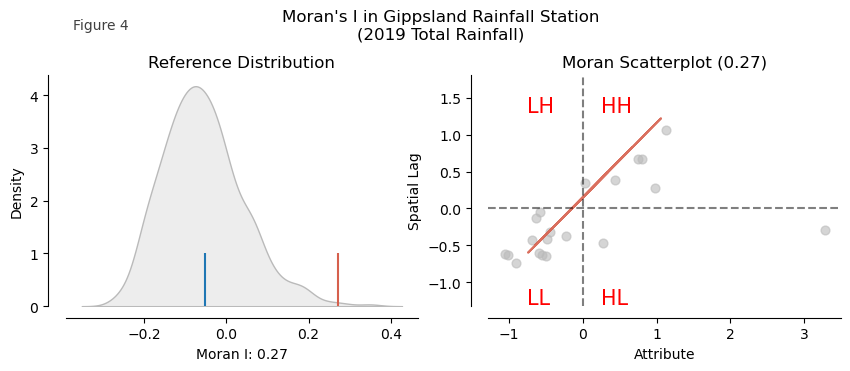

In [14]:
## -----
## Plotting Global Moran's I in rainfall stations
fig, ax = plot_moran(Rainfall_moran)
fig.set_size_inches(10, 3)
fig.suptitle("Moran's I in Gippsland Rainfall Station\n(2019 Total Rainfall)", fontsize = 12, y=1.1)

# Add text labels for each quadrant
ax[1].text(0.25, 1.3, "HH", fontsize=15, c="r")
ax[1].text(0.25, -1.3, "HL", fontsize=15, c="r")
ax[1].text(-0.75, 1.3, "LH", fontsize=15, c="r")
ax[1].text(-0.75, -1.3, "LL", fontsize=15, c="r")

ax[0].annotate(f'Figure 4', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.1, 1.2), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

plt.show()
## -----

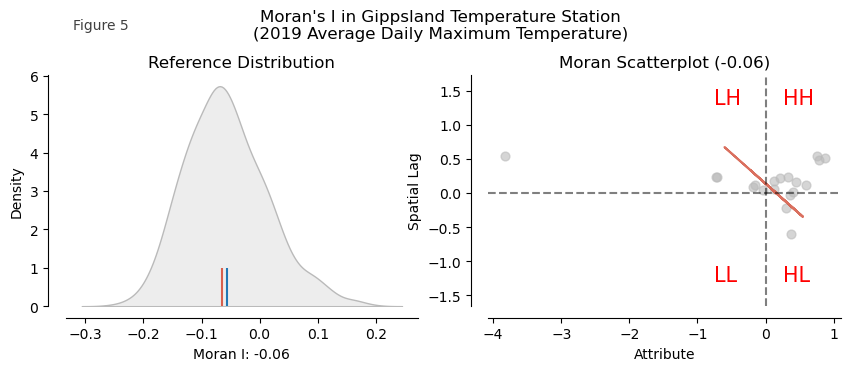

In [15]:
## -----
## Plotting Global Moran's I in temperature stations
fig, ax = plot_moran(Temperature_moran)
fig.set_size_inches(10, 3)
fig.suptitle("Moran's I in Gippsland Temperature Station\n(2019 Average Daily Maximum Temperature)", fontsize = 12, y=1.1)

# Add text labels for each quadrant
ax[1].text(0.25, 1.3, "HH", fontsize=15, c="r")
ax[1].text(0.25, -1.3, "HL", fontsize=15, c="r")
ax[1].text(-0.75, 1.3, "LH", fontsize=15, c="r")
ax[1].text(-0.75, -1.3, "LL", fontsize=15, c="r")

ax[0].annotate(f'Figure 5', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.1, 1.2), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

plt.show()
## -----

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">2019 Rainfall and Temperature Overview</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        Based on the calculation of annual rainfall amount in each stations in 2019 (Figure 3, left panel), it is observed that the central region of Gippsland experiences relatively lower rainfall (ranging from 366 mm to 480 mm), while the western region receives comparatively higher rainfall (exceeding 624 mm). Additionally, the calculation of average daily maximum temperatures in 2019 (Figure 3, right panel) reveals generally higher temperatures in the central region (above 20 degrees Celsius). 
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        The Moran's I value for rainfall is 0.27 (Figure 4), indicating a certain degree of spatial autocorrelation in rainfall distribution, with a higher concentration in the western region and relatively less in the central region. In contrast, the Moran's I index for temperature is negative, at -0.06, suggesting some degree of spatial randomness or dispersion. However, it's important to note that these calculations are limited by the data from only few stations, hence the scientific validity is yet to be fully confirmed.
    </p>
</div>

#### 2.3.2 Exam the Distribution 📊 of Rainfall and Temperature Data

In [16]:
## -----
## Using group by clause to sum up the monthly rainfall amount in each station
## and filter out the data less than 2020
Monthly_Rainfall_record = Rainfall_record.groupby(['Site', 'Name', 'Year', 'Month', 'geometry'], as_index=False)['Rainfall amount (millimetres)'].sum()
Monthly_Rainfall_record = Monthly_Rainfall_record[Monthly_Rainfall_record['Year'] <= 2020]
print('The monthly total rainfall amount in Gippsland station have been integrated.')
Monthly_Rainfall_record.head(3)
## -----

The monthly total rainfall amount in Gippsland station have been integrated.


,Site,Name,Year,Month,geometry,Rainfall amount (millimetres)
0,83090,OMEO,2015,1,POINT (553385.810 5893676.773),56.4
1,83090,OMEO,2015,2,POINT (553385.810 5893676.773),51.4
2,83090,OMEO,2015,3,POINT (553385.810 5893676.773),4.4


In [17]:
## used for estimating the optimal number of bins for a histogram
%pip install astropy

Note: you may need to restart the kernel to use updated packages.


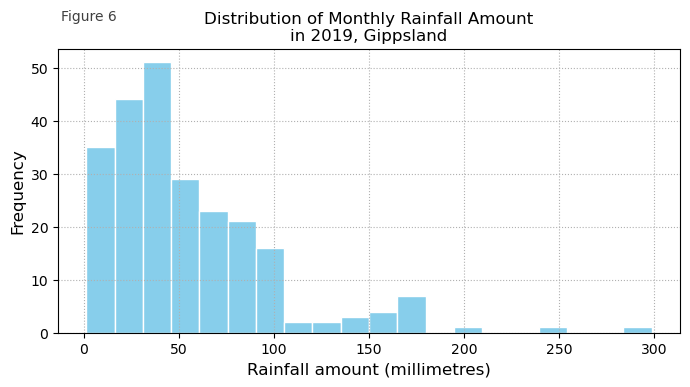

In [18]:
## -----
## Plotting the distribution of Monthly Rainfall Amount between 2015 and 2020 in Gippsland
from astropy.stats import knuth_bin_width

plt.figure(figsize=(7, 4))

# -----
# Determine the number of bins
# -----
# Using Knuth's rule to estimate the optimal number of bins in the monthly rainfall histogram,
# which is one of the Bayesian optimal bin estimators. It is based on a piece-wise constant functions
# and is applicable to the skewed and heavy-tailed distribution.
# This information is referred from https://medium.com/@maxmarkovvision/optimal-number-of-bins-for-histograms-3d7c48086fde

Monthly_Rainfall_record_2019 = Monthly_Rainfall_record[Monthly_Rainfall_record['Year'] == 2019]['Rainfall amount (millimetres)']

width, bin_edges = knuth_bin_width(Monthly_Rainfall_record_2019, return_bins=True)
plt.hist(Monthly_Rainfall_record_2019, bins=bin_edges, color = 'skyblue', edgecolor = 'white')

# formating
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.title('Distribution of Monthly Rainfall Amount\nin 2019, Gippsland', fontsize = 12)
plt.xlabel('Rainfall amount (millimetres)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.grid(True, linestyle=':')

plt.annotate(f'Figure 6', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.05, 1.1), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)


plt.tight_layout()
plt.show()
## -----

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Gippsland monthly rainfall in 2019</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        In 2019, the monthly total rainfall in Gippsland was predominantly distributed below 100mm, displaying a right-skewed trend (Figure 6), which deviates from a normal distribution pattern. Thus, in the next section, IDW interpolation was employed as a simulation method to depict the rainfall distribution across the entire Gippsland region. This approach was favored over kriging, as kriging is more suitable for normally distributed data (Esri).
    </p>
</div>

In [19]:
## -----
## Using group by clause to calculate the average monthly maximum temperature amount in each station
## and filter out the data later than 2020
Monthly_Temperature_record = Temperature_record.groupby(['Site', 'Name', 'Year', 'Month', 'geometry'], as_index=False)['Maximum temperature (Degree C)'].mean().dropna()
Monthly_Temperature_record = Monthly_Temperature_record[Monthly_Temperature_record['Year'] <= 2020]
print('The monthly average maximum daily temperature in Gippsland station have been integrated.')
Monthly_Temperature_record.head(3)
## -----

The monthly average maximum daily temperature in Gippsland station have been integrated.


,Site,Name,Year,Month,geometry,Maximum temperature (Degree C)
0,83090,OMEO,2015,1,POINT (553385.810 5893676.773),24.941935
1,83090,OMEO,2015,2,POINT (553385.810 5893676.773),26.800000
2,83090,OMEO,2015,3,POINT (553385.810 5893676.773),23.051613


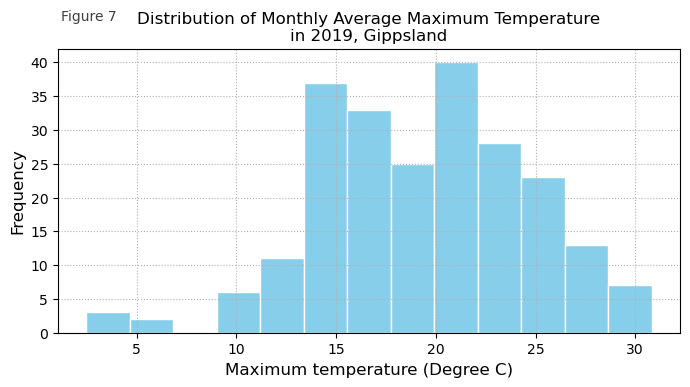

In [20]:
## -----
## Plotting the distribution of monthly average maximum temperature between 2015 and 2020 in Gippsland
plt.figure(figsize=(7, 4))

# -----
# Determine the number of bins
# -----
# Using Knuth's rule to estimate the optimal number of bins in the monthly temperature histogram,
# which is one of the Bayesian optimal bin estimators. It is based on a piece-wise constant functions
# and is applicable to the skewed, heavy-tailed and multi-modal distributions
# This information is referred from https://medium.com/@maxmarkovvision/optimal-number-of-bins-for-histograms-3d7c48086fde

Monthly_Temperature_record_2019 = Monthly_Temperature_record[Monthly_Temperature_record['Year'] == 2019]['Maximum temperature (Degree C)']

width, bin_edges = knuth_bin_width(Monthly_Temperature_record_2019, return_bins=True)
plt.hist(Monthly_Temperature_record_2019, bins=bin_edges, color = 'skyblue', edgecolor = 'white')

# formating
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.title('Distribution of Monthly Average Maximum Temperature\nin 2019, Gippsland', fontsize = 12)
plt.xlabel('Maximum temperature (Degree C)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.grid(True, linestyle=':')

plt.annotate(f'Figure 7', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.05, 1.1), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

plt.tight_layout()
plt.show()
## -----


<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Gippsland average monthly maximum temperature in 2019</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        In 2019, the daily maximum temperatures across Gippsland fluctuated between 10 and 30 degrees Celsius, displaying a trend (Figure 7) where frequencies were higher around 15 and 20 degrees. It seems the temperature distribution also deviates from normality. Hence, IDW interpolation was selected as the method for simulation in the subsequent section to depict the overall situation across the Gippsland region.
    </p>
</div>

### 2.4 Field Analysis

#### 2.4.1 IDW Interpolation

In [21]:
## -----
## Defining a raster grid
Gippsland_bounds = Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].bounds

minX = Gippsland_bounds.minx.values[0]
minY = Gippsland_bounds.miny.values[0]
maxX = Gippsland_bounds.maxx.values[0]
maxY = Gippsland_bounds.maxy.values[0]

cell_size = 1000 # resolution 1000m x 1000m
height = (maxY - minY)/cell_size
width = (maxX - minX)/cell_size

height = math.ceil(height)
width = math.ceil(width)
## -----

In [22]:
## -----
from idw_module import run_rblock

## Defining a function to perform IDW interpolation
def idw_method(data, feature, search_radius, p):
    ''' Returns a grid, that contains interpolated value
        -----
        Parameters
            data: dataframe name
            feature: attribute value to interpolated
            search_radius: the distance within which neighboring sample points are considered
            p: selected exponent
        -----
    '''
    global height, width, minX, minY, cell_size

    # create a blank raster grid to store the interpolated image
    blank_grid = np.ones((height, width))

    # list of x coordinates of the station coordinates
    x = data.geometry.x.astype(float).values.tolist()
    # list of y coordinates of the station coordinates
    y = data.geometry.y.astype(float).values.tolist()
    # list of attribute value to interpolate
    z = data[feature].values.tolist()

    for i in range(blank_grid.shape[0]): 
        yz = minY + cell_size * i

        for j in range(blank_grid.shape[1]): 
            xz = minX + cell_size * j

            # idw
            blank_grid[i][j] = run_rblock(x = x,
                                    y = y, 
                                    z = z, 
                                    xz = xz, 
                                    yz = yz, 
                                    r = search_radius, 
                                    p = p)

    return blank_grid
## -----

In [23]:
## -----
import rasterio.mask
from affine import Affine

## Defining a function to transform the interpolated idw grid into a georeferenced raster grid
## and clipping it into a Gippsland area
def idw_transform_clip(idw_grid, output_raster_name):
    '''  Returns a clipped raster file path
        -----
        Parameter
            idw_grid: the interpolated grid name
            output_raster_name: a output file name
        -----
    '''
    output_path = './output'
    ## create folder if it does not exist
    if not os.path.exists(output_path):
        os.mkdir(output_path)

    global height, width, minX, minY, cell_size

    ## transform the raster from grid coordinates to the georeferenced raster grid
    out_transform = Affine.translation(minX - cell_size/2, maxY - cell_size/2) * Affine.scale(cell_size, -cell_size)

    ## output raster filename
    out_raster_file = f'./output/{output_raster_name}.tif'

    ## the NODATA value is used for representing regions outside the study area (Gippsland Boundary)
    nodata = -9999

    ## store the output raster
    with rasterio.open(out_raster_file,
                    'w', 
                    driver = 'GTiff', 
                    dtype = np.float32,
                    height = height, 
                    width = width,
                    count = 1,
                    crs = 'EPSG:7855',
                    nodata = nodata,
                    transform = out_transform) as ds_out:
        # flipping the axis to sync between pixel and projected coordinate system
        ds_out.write(np.flip(idw_grid, axis = 0), 1)

    ## clip the output raster
    with rasterio.open(out_raster_file, 'r') as ras:
        profile = ras.profile
        masked_ras, masked_ras_transform = rasterio.mask.mask(dataset = ras, 
                                                            shapes = Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].geometry, 
                                                            nodata = nodata, 
                                                            crop = True)

        masked_ras_profile = profile.copy()
        masked_ras_profile['height'] = masked_ras.shape[1]
        masked_ras_profile['width'] = masked_ras.shape[2]
        masked_ras_profile['transform'] = masked_ras_transform
    
    ## store the clipped output raster
    raster_file_clipped = f'./output/{output_raster_name}_masked.tif'
    with rasterio.open(raster_file_clipped, 'w', **masked_ras_profile) as ds_out:
        ds_out.write(masked_ras)

    return raster_file_clipped
## -----

In [24]:
## -----
## Simulating the rainfall amount in 2019 across Gippsland
Rainfall_idw_grid_2019 = idw_method(data = Rainfall_record_2019_annual, feature = 'Rainfall amount (millimetres)', search_radius = 100000, p = 1.5)
Rainfall_2019_raster_clipped = idw_transform_clip(Rainfall_idw_grid_2019, 'rainfall_2019')


## Calculating the difference of rainfall amount between the average of 2015 - 2018 and 2019 across Gippsland's stations
Rainfall_record_annual = Rainfall_record.groupby(['Site', 'Name', 'Year', 'geometry'], as_index=False)['Rainfall amount (millimetres)'].sum()
Rainfall_record_1518_annual = Rainfall_record_annual[(Rainfall_record_annual.Year >= 2015) & (Rainfall_record_annual.Year <= 2018)].groupby(['Site', 'Name', 'geometry'], as_index=False)['Rainfall amount (millimetres)'].mean()
Rainfall_record_1518_annual = gpd.GeoDataFrame(Rainfall_record_1518_annual, geometry=Rainfall_record_1518_annual.geometry)

Rainfall_record_diff_annual = Rainfall_record_2019_annual.copy()
Rainfall_record_diff_annual['Rainfall amount (millimetres) diff'] = Rainfall_record_1518_annual['Rainfall amount (millimetres)'] - Rainfall_record_2019_annual['Rainfall amount (millimetres)']
Rainfall_record_diff_annual = Rainfall_record_diff_annual.drop(columns= ['Rainfall amount (millimetres)'])


## Simulating the difference of rainfall amount between the average of 2015 - 2018 and 2019 across Gippsland
Rainfall_idw_grid_diff = idw_method(data = Rainfall_record_diff_annual, feature = 'Rainfall amount (millimetres) diff', search_radius = 100000, p = 1.5)
Rainfall_diff_raster_clipped = idw_transform_clip(Rainfall_idw_grid_diff, 'rainfall_diff')
## -----

In [25]:
## loading bushfire records
Fire_hist_gpd = gpd.read_file('data/FIRE.gdb')
Fire_19 = Fire_hist_gpd[(Fire_hist_gpd.START_DATE_INT >= 20190101) & (Fire_hist_gpd.START_DATE_INT <= 20191231)]
Fire_19 = gpd.clip(Fire_19, Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].geometry)
Fire_19 = Fire_19[Fire_19.FIRETYPE == 'BUSHFIRE'].reset_index(drop = True)

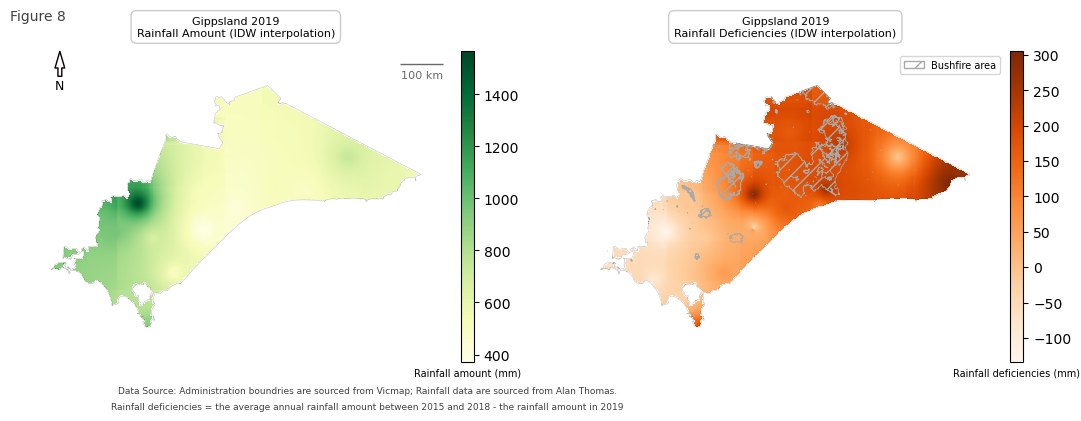

In [26]:
## -----
import rasterio.plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Polygon, Patch

## Plotting the interpolated rainfall amount in 2019 across Gippsland
## ----- ----- ----- ----- -----

fig, axs = plt.subplots(1, 2, figsize=(13, 5.5), sharey = True)
with rasterio.open(Rainfall_2019_raster_clipped, 'r') as ds:
    img_arr = ds.read(1)

## assigning nodata value as NaN
img_arr[img_arr == ds.nodata] = np.NaN

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='3%', pad=0.05)
cax.set_xlabel('Rainfall amount (mm)', loc='center', fontsize = 7)

im = rasterio.plot.show(img_arr, ax = axs[0], transform = ds.transform, cmap = 'YlGn')
im = im.get_images()[0]
fig.colorbar(im, cax=cax, orientation='vertical')

# set the plot boundary to dataset.bounds
n = 40
axs[0].set_xlim(ds.bounds.left - n*cell_size, ds.bounds.right + n*cell_size)
axs[0].set_ylim(ds.bounds.bottom - n*cell_size, ds.bounds.top + n*cell_size)

Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].plot(ax = axs[0], 
                facecolor="none", 
                edgecolor="k", 
                linewidth=0.3, 
                alpha = 0.3)
## ----- ----- ----- ----- -----

## Plotting the interpolated rainfall deficient amount in 2019 across Gippsland
## ----- ----- ----- ----- -----
with rasterio.open(Rainfall_diff_raster_clipped, 'r') as ds:
    img_arr = ds.read(1)

# assigning nodata value as NaN
img_arr[img_arr == ds.nodata] = np.NaN

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='3%', pad=0.05)
cax.set_xlabel('Rainfall deficiencies (mm)', loc='center', fontsize = 7)

im = rasterio.plot.show(img_arr, ax = axs[1], transform = ds.transform, cmap = 'Oranges')
im = im.get_images()[0]
fig.colorbar(im, cax=cax, orientation='vertical')
Fire_19.plot(ax=axs[1], facecolor='none', edgecolor='darkgray', linewidth=0.5, hatch='//')

# Create a custom legend handle
legend_handle = Patch(facecolor='none', edgecolor='darkgray', hatch='//', label='Bushfire area')
# Add the legend to the plot
axs[1].legend(handles=[legend_handle], fontsize=7)

# set the plot boundary to dataset.bounds
n = 40
axs[1].set_xlim(ds.bounds.left - n*cell_size, ds.bounds.right + n*cell_size)
axs[1].set_ylim(ds.bounds.bottom - n*cell_size, ds.bounds.top + n*cell_size)

Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].plot(ax = axs[1], 
                facecolor="none", 
                edgecolor="k", 
                linewidth=0.3, 
                alpha = 0.3)
## ----- ----- ----- ----- -----

## Adding the title, data source, orientational arrow
axs[0].annotate(f'Gippsland 2019\nRainfall Amount (IDW interpolation)', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.5, 1.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=8, color='black',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='black', boxstyle='round,pad=0.5'))

axs[1].annotate(f'Gippsland 2019\nRainfall Deficiencies (IDW interpolation)', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.5, 1.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=8, color='black',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='black', boxstyle='round,pad=0.5'))

axs[0].annotate(f'Data Source: Administration boundries are sourced from Vicmap; Rainfall data are sourced from Alan Thomas.', xy=(0.23, 0.9),      xycoords='axes fraction', xytext=(0.8, -0.1), textcoords='axes fraction', horizontalalignment='center', fontsize=6.5, color='black', alpha=0.75)

axs[0].annotate(f'Rainfall deficiencies = the average annual rainfall amount between 2015 and 2018 - the rainfall amount in 2019', xy=(0.23, 0.9),      xycoords='axes fraction', xytext=(0.8, -0.15), textcoords='axes fraction', horizontalalignment='center', fontsize=6.5, color='black', alpha=0.75)

# -- Python Citation 1 --
# The following snippet of code aims to add a 'North Arrow'
# And it is impelmented based on a suggestion from Steven in 2019.
# https://stackoverflow.com/questions/58088841/how-to-add-a-north-arrow-on-a-geopandas-map
# ----- ----- ----- ----- -----
x, y, arrow_length = 0.1, 1, 0.11
axs[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
        arrowprops=dict(facecolor='snow', width=2.75, headwidth=7),
        ha='center', va='center', fontsize=9,
        xycoords=axs[0].transAxes)
# ----- ----- ----- ----- -----

axs[0].set_axis_off()
## scale ruler
fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(axs[0].transData,
                        50000, '100 km', 'upper right',
                        pad=0.1,
                        borderpad=1,
                        sep=5,
                        color='dimgray',
                        frameon=False,
                        size_vertical=1,
                        fontproperties=fontprops)
axs[0].add_artist(scalebar)

axs[0].annotate(f'Figure 8', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.05, 1.1), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

axs[1].set_axis_off()

# plt.savefig('Figure8.png', format='png', bbox_inches='tight')

plt.show()
## -----

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Rainfall Deficiencies and Bushfire Areas</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        In this analysis section, we introduce the concept of rainfall deficiencies, which refers to the difference between the total rainfall in 2019 and the average annual rainfall from 2015 to 2018. Analyzing the deficiency in rainfall across different regions of Gippsland provides a more accurate understanding of which areas experienced significantly reduced rainfall compared to previous years.
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        As illustrated in Figure 8 (left panel), the central region of Gippsland had the least rainfall in 2019 compared to other areas, with more rainfall concentrated in the western region. Additionally, observing Figure 8 (right panel) reveals a significant decrease in rainfall in the central region compared to previous years, while the western region experienced increased rainfall. This phenomenon suggests the presence of the El Niño, with most bushfires occurring in the central region during that year. It is worth noting that in the East Gippsland region, the maximum deficiency in rainfall reached 300mm, indicating some meteorological signals of the 2019-20 Black Summer.
    </p>
</div>

In [27]:
## -----
## Simulating the temperature (average daily maximum temperature) in 2019 across Gippsland
Temperature_idw_grid_2019 = idw_method(data = Temperature_record_2019_annual, feature = 'Maximum temperature (Degree C)', search_radius = 100000, p = 1.5)
Temperature_2019_raster_clipped = idw_transform_clip(Temperature_idw_grid_2019, 'temperature_2019')


## Calculating the difference of temperature between the average of 2015 - 2018 and 2019 across Gippsland's stations
Temperature_record_annual = Temperature_record.groupby(['Site', 'Name', 'Year', 'geometry'], as_index=False)['Maximum temperature (Degree C)'].mean()
Temperature_record_1518_annual = Temperature_record_annual[(Temperature_record_annual.Year >= 2015) & (Temperature_record_annual.Year <= 2018)].groupby(['Site', 'Name', 'geometry'], as_index=False)['Maximum temperature (Degree C)'].mean()
Temperature_record_1518_annual = gpd.GeoDataFrame(Temperature_record_1518_annual, geometry=Temperature_record_1518_annual.geometry)

Temperature_record_diff_annual = Temperature_record_2019_annual.copy()
Temperature_record_diff_annual['Maximum temperature (Degree C) diff'] = Temperature_record_2019_annual['Maximum temperature (Degree C)'] - Temperature_record_1518_annual['Maximum temperature (Degree C)']
Temperature_record_diff_annual = Temperature_record_diff_annual.drop(columns= ['Maximum temperature (Degree C)'])


## Simulating the difference of temperature between the average of 2015 - 2018 and 2019 across Gippsland
Temperature_idw_grid_diff = idw_method(data = Temperature_record_diff_annual, feature = 'Maximum temperature (Degree C) diff', search_radius = 100000, p = 1.5)
Temperature_diff_raster_clipped = idw_transform_clip(Temperature_idw_grid_diff, 'temperature_diff')
## -----

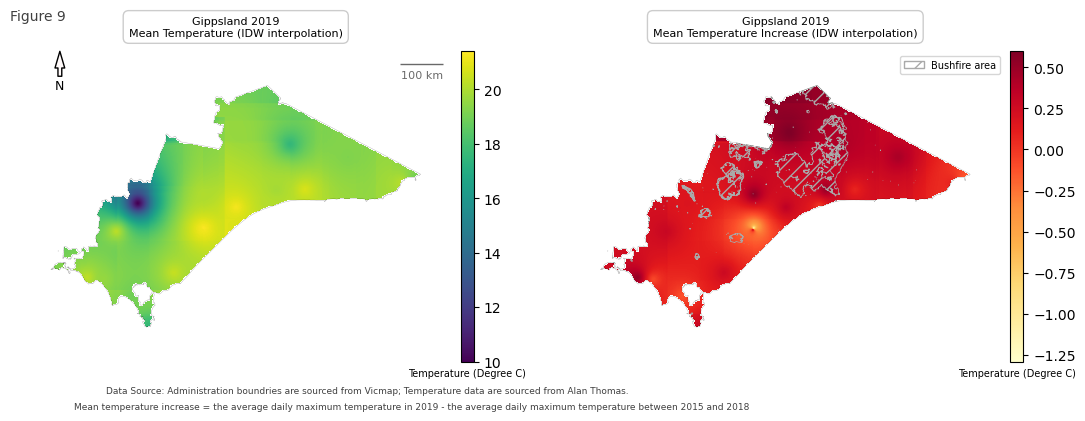

In [28]:
## -----
import rasterio.plot
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 2, figsize=(13, 5.5), sharey = True)

## Plotting the interpolated temperature in 2019 across Gippsland
## ----- ----- ----- ----- -----
with rasterio.open(Temperature_2019_raster_clipped, 'r') as ds:
    img_arr = ds.read(1)

## assigning nodata value as NaN
img_arr[img_arr == ds.nodata] = np.NaN

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='3%', pad=0.05)
cax.set_xlabel('Temperature (Degree C)', loc='center', fontsize = 7)

im = rasterio.plot.show(img_arr, ax = axs[0], transform = ds.transform)
im = im.get_images()[0]
fig.colorbar(im, cax=cax, orientation='vertical')

# set the plot boundary to dataset.bounds
n = 40
axs[0].set_xlim(ds.bounds.left - n*cell_size, ds.bounds.right + n*cell_size)
axs[0].set_ylim(ds.bounds.bottom - n*cell_size, ds.bounds.top + n*cell_size)

Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].plot(ax = axs[0], 
                facecolor="none", 
                edgecolor="k", 
                linewidth=0.3, 
                alpha = 0.3)
## ----- ----- ----- ----- -----

## Plotting the interpolated temperature difference in 2019 across Gippsland
## ----- ----- ----- ----- -----
with rasterio.open(Temperature_diff_raster_clipped, 'r') as ds:
    img_arr = ds.read(1)

## assigning nodata value as NaN
img_arr[img_arr == ds.nodata] = np.NaN

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='3%', pad=0.05)
cax.set_xlabel('Temperature (Degree C)', loc='center', fontsize = 7)

im = rasterio.plot.show(img_arr, ax = axs[1], transform = ds.transform, cmap = 'YlOrRd')
im = im.get_images()[0]
fig.colorbar(im, cax=cax, orientation='vertical')

Fire_19.plot(ax=axs[1], facecolor='none', edgecolor='darkgray', linewidth=0.5, hatch='//')

# Create a custom legend handle
legend_handle = Patch(facecolor='none', edgecolor='darkgray', hatch='//', label='Bushfire area')
# Add the legend to the plot
axs[1].legend(handles=[legend_handle], fontsize=7)

# set the plot boundary to dataset.bounds
n = 40
axs[1].set_xlim(ds.bounds.left - n*cell_size, ds.bounds.right + n*cell_size)
axs[1].set_ylim(ds.bounds.bottom - n*cell_size, ds.bounds.top + n*cell_size)

Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].plot(ax = axs[1], 
                facecolor="none", 
                edgecolor="k", 
                linewidth=0.3, 
                alpha = 0.3)
## ----- ----- ----- ----- -----

## Adding the title, data source, orientational arrow
axs[0].annotate(f'Gippsland 2019\nMean Temperature (IDW interpolation)', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.5, 1.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=8, color='black',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='black', boxstyle='round,pad=0.5'))

axs[1].annotate(f'Gippsland 2019\nMean Temperature Increase (IDW interpolation)', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.5, 1.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=8, color='black',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='black', boxstyle='round,pad=0.5'))

axs[0].annotate(f'Data Source: Administration boundries are sourced from Vicmap; Temperature data are sourced from Alan Thomas.', xy=(0.23, 0.9),      xycoords='axes fraction', xytext=(0.8, -0.1), textcoords='axes fraction', horizontalalignment='center', fontsize=6.5, color='black', alpha=0.75)

axs[0].annotate(f'Mean temperature increase = the average daily maximum temperature in 2019 - the average daily maximum temperature between 2015 and 2018', xy=(0.23, 0.9), xycoords='axes fraction', xytext=(0.9, -0.15), textcoords='axes fraction', horizontalalignment='center', fontsize=6.5, color='black', alpha=0.75)

# -- Python Citation 1 --
# The following snippet of code aims to add a 'North Arrow'
# And it is impelmented based on a suggestion from Steven in 2019.
# https://stackoverflow.com/questions/58088841/how-to-add-a-north-arrow-on-a-geopandas-map
# ----- ----- ----- ----- -----
x, y, arrow_length = 0.1, 1, 0.11
axs[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
        arrowprops=dict(facecolor='snow', width=2.75, headwidth=7),
        ha='center', va='center', fontsize=9,
        xycoords=axs[0].transAxes)
# ----- ----- ----- ----- -----

axs[0].set_axis_off()
fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(axs[0].transData,
                        50000, '100 km', 'upper right',
                        pad=0.1,
                        borderpad=1,
                        sep=5,
                        color='dimgray',
                        frameon=False,
                        size_vertical=1,
                        fontproperties=fontprops)
axs[0].add_artist(scalebar)

axs[0].annotate(f'Figure 9', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.05, 1.1), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

axs[1].set_axis_off()

# plt.savefig('Figure9.png', format='png', bbox_inches='tight')
## -----

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Temperature Increase and Bushfire Areas</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        In this section, the concept of temperature increase is introduced, which refers to the difference in the average daily maximum temperature in Gippsland between 2019 and the period from 2015 to 2018. Calculating this difference helps us better understand the relationship between areas experiencing temperature increases and regions affected by bushfires.
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        The central region of Gippsland remains noteable. In 2019, the average daily maximum temperature in this region was nearly 20 degrees Celsius (Figure 9, left panel). Additionally, throughout the year, there was a general increase in temperatures across the entire Gippsland region (Figure 9, right panel). It is possible to speculate that the wildfires in the central region are related to the high temperatures there. However, it cannot be definitively concluded that the temperature increase in 2019 compared to previous years directly caused the bushfires.
    </p>
</div>

# 3 Main Analysis

## 3.1 Correlation Analysis

###  3.1.1 Rainfall and temperature correlation analysis

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Correlation Analysis Overview</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        In this section, we aim to explore the correlation between environmental factors (rainfall and temperature) and fire frequency in the Gippsland region during the year 2019. By leveraging spatial raster data for rainfall, temperature, and fire frequency, we will analyze how variations in these factors may influence the occurrence of bushfires.
    </p>
</div>


In [29]:
# Read and reproject fire data
fire_data_path = 'data/FIRE.gdb'
fire_gdf = gpd.read_file(fire_data_path).to_crs(epsg=7855)

# Remove duplicates from fire data
fire_gdf = fire_gdf.drop_duplicates()

# Read and reproject Gippsland boundary data
gipbound_data_path = 'data/Gippsland.shp'
gipbound_gdf = gpd.read_file(gipbound_data_path).to_crs(epsg=7855)

# Filter fire data for 2019
fire_gdf['START DATE'] = pd.to_datetime(fire_gdf['START_DATE_INT'], format='%Y%m%d')
fire_2019 = fire_gdf[(fire_gdf['START DATE'] >= '2019-01-01') & (fire_gdf['START DATE'] <= '2019-12-31')]

# Further filter for BUSHFIRE type
bushfire_2019 = fire_2019[fire_2019['FIRETYPE'] == 'BUSHFIRE']

# Clip fire data for Gippsland region
fire_2019_gippsland = bushfire_2019.clip(gipbound_gdf)

# Count fire occurrences
fire_counts_2019 = fire_2019_gippsland.groupby('FIRE_NO').size().reset_index(name='fire_count')
fire_frequency_2019 = fire_2019_gippsland.merge(fire_counts_2019, on='FIRE_NO')



In [30]:

# Define the bounds and pixel size for rasterization
bounds = fire_frequency_2019.total_bounds
pixel_size = 1000  # 1 km x 1 km
x_min, y_min, x_max, y_max = bounds
width = int((x_max - x_min) / pixel_size)
height = int((y_max - y_min) / pixel_size)
common_shape = (height, width)

# Define the transform for rasterization
common_transform = rasterio.transform.from_bounds(x_min, y_min, x_max, y_max, width, height)
common_crs = 'EPSG:7855' 
# Create fire frequency raster
fire_frequency_raster = rasterize(
    [(geom, count) for geom, count in zip(fire_frequency_2019.geometry, fire_frequency_2019['fire_count'])],
    out_shape=common_shape,
    transform=common_transform,
    fill=0,
    dtype=np.float32
)


# Save fire frequency raster
fire_frequency_raster_path = 'output/fire_frequency_2019.tif'
with rasterio.open(
    fire_frequency_raster_path, 'w', driver='GTiff', height=common_shape[0],
    width=common_shape[1], count=1, dtype=np.float32, crs=common_crs, transform=common_transform
) as dst:
    dst.write(fire_frequency_raster, 1)



In [31]:
# Read the original data
rainfall_raster_path = 'output/rainfall_2019_masked_reprojected.tif'
temperature_raster_path = 'output/temperature_2019_masked_reprojected.tif'

with rasterio.open(rainfall_raster_path) as src:
    original_rainfall_data = src.read(1)
    rainfall_meta = src.meta

with rasterio.open(temperature_raster_path) as src:
    original_temperature_data = src.read(1)
    temperature_meta = src.meta

# Replace invalid values with NaN
original_rainfall_data[original_rainfall_data == -9999.0] = np.nan
original_temperature_data[original_temperature_data == -9999.0] = np.nan


# Function to reproject raster to common area
def reproject_raster(source_raster_path, dest_raster_path, dest_transform, dest_crs, dest_shape):
    with rasterio.open(source_raster_path) as src:
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dest_crs,
            'transform': dest_transform,
            'width': dest_shape[1],
            'height': dest_shape[0]
        })
        
        with rasterio.open(dest_raster_path, 'w', **kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dest_transform,
                dst_crs=dest_crs,
                resampling=Resampling.nearest)


# Reproject rainfall and temperature data to common area
reproject_raster('output/rainfall_2019_masked_reprojected.tif', 'output/rainfall_2019_common.tif', common_transform, common_crs, common_shape)
reproject_raster('output/temperature_2019_masked_reprojected.tif', 'output/temperature_2019_common.tif', common_transform, common_crs, common_shape)


In [32]:

# Read aligned raster data for rainfall, temperature, and fire frequency
aligned_rainfall_raster_path = 'output/rainfall_2019_common.tif'
aligned_temperature_raster_path = 'output/temperature_2019_common.tif'

with rasterio.open(aligned_rainfall_raster_path) as src:
    aligned_rainfall_data = src.read(1)
    aligned_rainfall_meta = src.meta

with rasterio.open(aligned_temperature_raster_path) as src:
    aligned_temperature_data = src.read(1)
    aligned_temperature_meta = src.meta

with rasterio.open(fire_frequency_raster_path) as src:
    aligned_fire_frequency_data = src.read(1)
    aligned_fire_frequency_meta = src.meta


# Replace invalid values with NaN
aligned_rainfall_data[aligned_rainfall_data == -9999.0] = np.nan
aligned_temperature_data[aligned_temperature_data == -9999.0] = np.nan
aligned_fire_frequency_data[aligned_fire_frequency_data == -9999.0] = np.nan

# Flatten data and filter NaNs
flat_rainfall = aligned_rainfall_data.flatten()
flat_temperature = aligned_temperature_data.flatten()
flat_fire_frequency = aligned_fire_frequency_data.flatten()

valid_mask = (~np.isnan(flat_rainfall)) & (~np.isnan(flat_temperature)) & (~np.isnan(flat_fire_frequency))

filtered_rainfall = flat_rainfall[valid_mask]
filtered_temperature = flat_temperature[valid_mask]
filtered_fire_frequency = flat_fire_frequency[valid_mask]


# Calculate correlation for fire frequency
if len(filtered_rainfall) == 0 or len(filtered_fire_frequency) == 0:
    print("No valid values for rainfall or fire frequency data, cannot calculate correlation")
else:
    rainfall_fire_frequency_corr, _ = pearsonr(filtered_rainfall, filtered_fire_frequency)
    print(f'Correlation between rainfall and fire frequency: {round(rainfall_fire_frequency_corr, 4)}')

if len(filtered_temperature) == 0 or len(filtered_fire_frequency) == 0:
    print("No valid values for temperature or fire frequency data, cannot calculate correlation")
else:
    temperature_fire_frequency_corr, _ = pearsonr(filtered_temperature, filtered_fire_frequency)
    print(f'Correlation between temperature and fire frequency: {round(temperature_fire_frequency_corr, 4)}')


Correlation between rainfall and fire frequency: -0.2044
Correlation between temperature and fire frequency: 0.0623


<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Correlation Analysis:</strong>
    <p style="margin-right:60px; line-height: 1.5;">
    <br>
    The correlation analysis between climate factors (rainfall and temperature) and fire frequency in the Gippsland region for the year 2019 yielded the following results:
    <ul>
        <li><strong>Correlation between Rainfall and Fire Frequency:</strong> -0.2044</li>
        <p style="margin-right:60px; line-height: 1.5;">
        This negative correlation indicates that higher rainfall is generally associated with a lower frequency of fire incidents. In other words, areas with more rainfall tend to experience fewer fires, which suggests that increased moisture may reduce the likelihood of fire occurrence.
        </p>
        <li><strong>Correlation between Temperature and Fire Frequency:</strong> 0.0623</li>
        <p style="margin-right:60px; line-height: 1.5;">
        This weak positive correlation suggests a slight association between higher temperatures and increased fire frequency. Although the correlation is not strong, it implies that higher temperatures may contribute to a higher number of fire incidents, but other factors also play significant roles.
        </p>
    </ul>
    <p style="margin-right:60px; line-height: 1.5;">
    Overall, the analysis highlights the inverse relationship between rainfall and fire frequency, and a weaker direct relationship between temperature and fire frequency. This information is crucial for understanding how climatic conditions influence fire patterns and can help in developing better fire management and prevention strategies.
    </p>
</div>


In [33]:
# Prepare box plot data
rainfall_with_fire = aligned_rainfall_data[aligned_fire_frequency_data > 0].flatten()
rainfall_no_fire = aligned_rainfall_data[aligned_fire_frequency_data == 0].flatten()

temperature_with_fire = aligned_temperature_data[aligned_fire_frequency_data > 0].flatten()
temperature_no_fire = aligned_temperature_data[aligned_fire_frequency_data == 0].flatten()

# Remove NaN values
rainfall_with_fire = rainfall_with_fire[~np.isnan(rainfall_with_fire)]
rainfall_no_fire = rainfall_no_fire[~np.isnan(rainfall_no_fire)]

temperature_with_fire = temperature_with_fire[~np.isnan(temperature_with_fire)]
temperature_no_fire = temperature_no_fire[~np.isnan(temperature_no_fire)]


In [34]:
# Basic statistical analysis
rainfall_with_fire_stats = pd.Series(rainfall_with_fire).describe()
rainfall_no_fire_stats = pd.Series(rainfall_no_fire).describe()

temperature_with_fire_stats = pd.Series(temperature_with_fire).describe()
temperature_no_fire_stats = pd.Series(temperature_no_fire).describe()

# Print basic statistics
print('Rainfall statistics when fire occurs:')
print(rainfall_with_fire_stats)
print('\nRainfall statistics when no fire occurs:')
print(rainfall_no_fire_stats)

print('\nTemperature statistics when fire occurs:')
print(temperature_with_fire_stats)
print('\nTemperature statistics when no fire occurs:')
print(temperature_no_fire_stats)

# Determine threshold values
rainfall_threshold = rainfall_with_fire_stats['25%']
temperature_threshold = temperature_with_fire_stats['75%']

print(f'\nSuggested Rainfall Threshold: {rainfall_threshold:.2f} mm')
print(f'Suggested Temperature Threshold: {temperature_threshold:.2f} °C')



Rainfall statistics when fire occurs:
count    5373.000000
mean      548.928833
std       112.452248
min       458.357605
25%       497.026672
50%       515.142761
75%       546.278442
max      1371.896362
dtype: float64

Rainfall statistics when no fire occurs:
count    33673.000000
mean       651.880859
std        192.604492
min        369.841187
25%        504.583466
50%        579.164978
75%        771.971680
max       1565.987183
dtype: float64

Temperature statistics when fire occurs:
count    5373.000000
mean       19.231661
std         1.031304
min        11.778825
25%        18.772104
50%        19.368389
75%        19.944586
max        20.675694
dtype: float64

Temperature statistics when no fire occurs:
count    33673.000000
mean        19.156616
std          1.426668
min          9.972907
25%         19.021582
50%         19.389828
75%         19.878592
max         21.396183
dtype: float64

Suggested Rainfall Threshold: 497.03 mm
Suggested Temperature Threshold: 19.94 °C


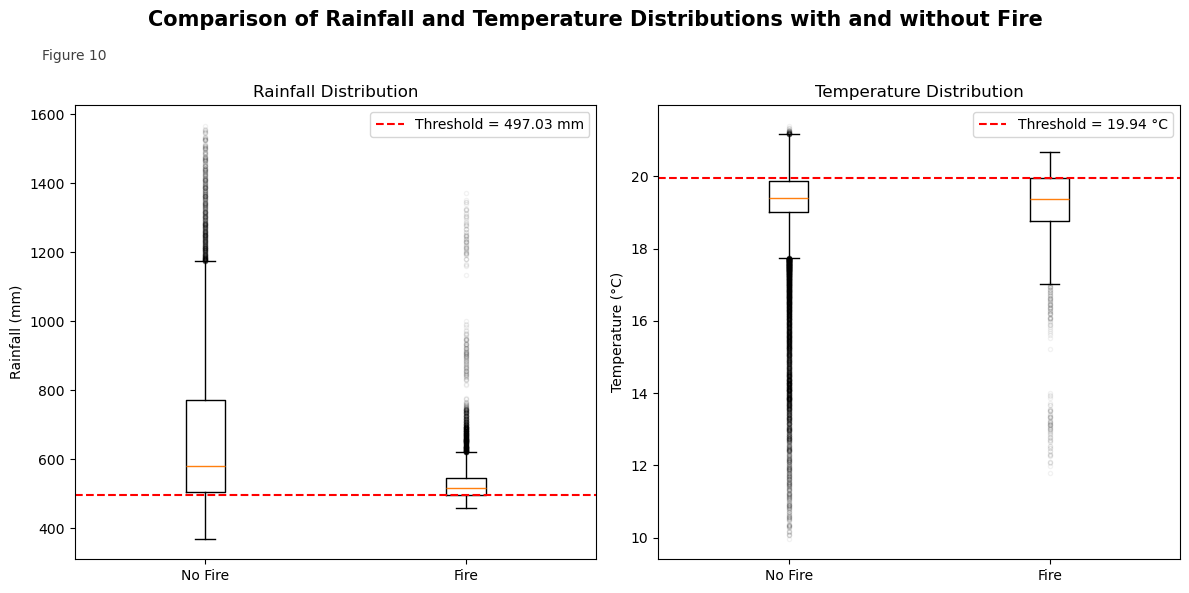

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot rainfall boxplot
axs[0].boxplot([rainfall_no_fire, rainfall_with_fire], labels=['No Fire', 'Fire'], flierprops=dict(marker='.', color='lightgrey', alpha=0.05))
axs[0].axhline(rainfall_threshold, color='r', linestyle='--', label=f'Threshold = {rainfall_threshold:.2f} mm')
axs[0].set_title('Rainfall Distribution')
axs[0].set_ylabel('Rainfall (mm)')
axs[0].legend()

# Plot temperature boxplot
axs[1].boxplot([temperature_no_fire, temperature_with_fire], labels=['No Fire', 'Fire'], flierprops=dict(marker='.', color='lightgrey', alpha=0.05))
axs[1].axhline(temperature_threshold, color='r', linestyle='--', label=f'Threshold = {temperature_threshold:.2f} °C')
axs[1].set_title('Temperature Distribution')
axs[1].set_ylabel('Temperature (°C)')
axs[1].legend()

axs[0].annotate(f'Figure 10', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0, 1.1), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

# Add a main title
fig.suptitle('Comparison of Rainfall and Temperature Distributions with and without Fire', fontweight='bold', size = 15)

plt.tight_layout()
plt.show()

<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Box Plot Analysis:</strong>
    <br>
    The figure 10 displays box plots comparing the distributions of rainfall and temperature in areas with and without fire incidents in the Gippsland region for the year 2019. The red dashed lines represent the calculated thresholds for rainfall and temperature, derived from the 25th percentile of rainfall in fire-affected areas and the 75th percentile of temperature in fire-affected areas.
    <ul>
        <li><strong>Rainfall Distribution (Left Panel):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The box plot on the left shows the distribution of rainfall in areas with and without fire incidents. The threshold for rainfall is 497.03 mm (marked by the red dashed line), which is the 25th percentile of rainfall in areas with fire incidents. The median rainfall in areas without fire incidents is significantly higher than the threshold, indicating that higher rainfall generally correlates with a lower likelihood of fire. Conversely, in areas with fire incidents, the median rainfall is around the threshold, suggesting that lower rainfall is associated with an increased likelihood of fire.
        </p>
        
<li><strong>Temperature Distribution (Right Panel):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The box plot on the right illustrates the distribution of temperature in areas with and without fire incidents. The threshold for temperature is 19.94 °C (marked by the red dashed line), which is the 75th percentile of temperature in areas with fire incidents. The median temperature in areas with fire incidents is higher than this threshold, indicating that higher temperatures are generally associated with a higher likelihood of fire. In contrast, areas without fire incidents have a median temperature below the threshold, suggesting that lower temperatures are associated with a decreased likelihood of fire.
        </p>
</ul>
    <p style="margin-right:60px; line-height: 1.5;">
    Overall, the box plots clearly demonstrate the relationships between climate factors (rainfall and temperature) and the occurrence of fire incidents. Higher rainfall tends to reduce the likelihood of fire, while higher temperatures increase the likelihood of fire. These thresholds provide a useful reference for understanding and predicting fire risks based on climatic conditions.
    </p>
</div>


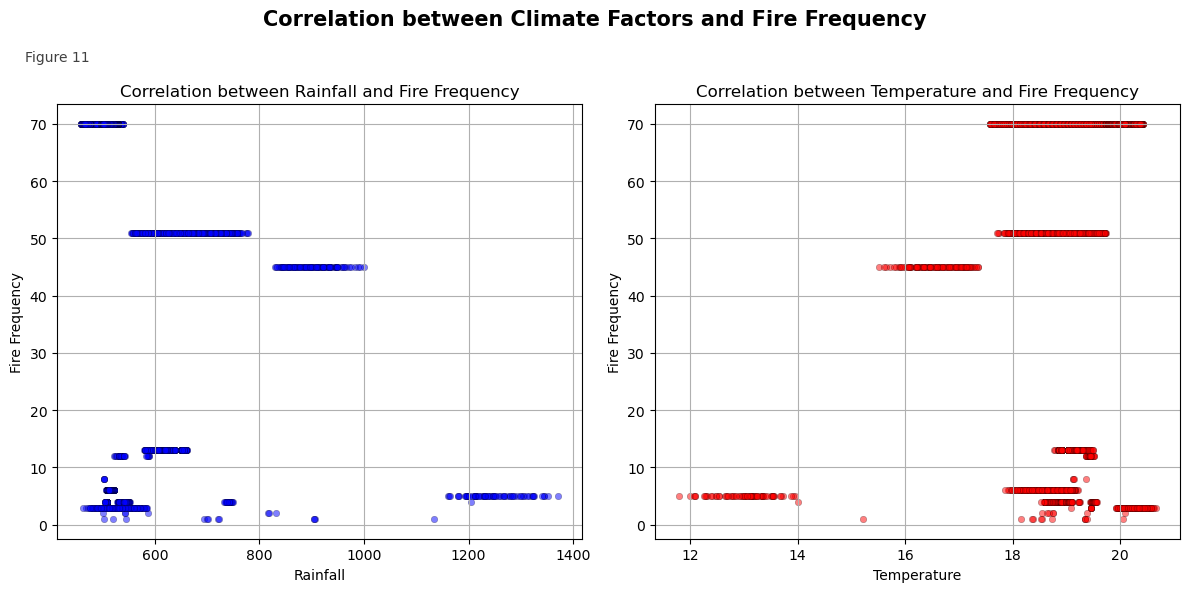

In [36]:
# Keep only data points with fires
valid_indices = filtered_fire_frequency > 0
filtered_rainfall_fire = filtered_rainfall[valid_indices]
filtered_temperature_fire = filtered_temperature[valid_indices]
filtered_fire_frequency_fire = filtered_fire_frequency[valid_indices]

# Plot (only show data points with fires)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(filtered_rainfall_fire, filtered_fire_frequency_fire, alpha=0.5, c='blue', s = 22, edgecolors='black', linewidths=0.28)
plt.xlabel('Rainfall')
plt.ylabel('Fire Frequency')
plt.title('Correlation between Rainfall and Fire Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(filtered_temperature_fire, filtered_fire_frequency_fire, alpha=0.5, c='red', s= 22, edgecolors='black', linewidths=0.28)
plt.xlabel('Temperature')
plt.ylabel('Fire Frequency')
plt.title('Correlation between Temperature and Fire Frequency')
plt.grid(True)

plt.suptitle('Correlation between Climate Factors and Fire Frequency', fontweight='bold', size = 15)

plt.subplot(1, 2, 1)
plt.annotate(f'Figure 11', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0, 1.1), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

plt.tight_layout()
plt.show()

<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Scatter Plot Analysis:</strong>
    <br>
    The figure 11 presents scatter plots illustrating the correlation between climate factors (rainfall and temperature) and fire frequency, focusing only on data points where fires occurred in the Gippsland region for the year 2019.
    <ul>
        <li><strong>Correlation between Rainfall and Fire Frequency (Left Panel):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The scatter plot on the left shows the relationship between rainfall and fire frequency. The points represent the number of fire incidents at different levels of rainfall. It is evident that higher fire frequencies are associated with lower rainfall values. Most high-frequency fire incidents occur when the rainfall is below approximately 800 mm, indicating a negative correlation between rainfall and fire frequency.
        </p>
        
<li><strong>Correlation between Temperature and Fire Frequency (Right Panel):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The scatter plot on the right illustrates the relationship between temperature and fire frequency. The points represent the number of fire incidents at different temperature levels. The plot shows that higher fire frequencies are generally associated with higher temperatures. Most high-frequency fire incidents occur when the temperature is above approximately 18°C, indicating a positive correlation between temperature and fire frequency.
        </p>
    </ul>
    <p style="margin-right:60px; line-height: 1.5;">
    Overall, these scatter plots reinforce the observed correlations: lower rainfall tends to be associated with higher fire frequencies, while higher temperatures tend to correlate with increased fire frequencies. These relationships highlight the significant impact of climatic conditions on the occurrence and frequency of fires, providing valuable insights for fire management and prevention strategies.
    </p>
</div>



## 3.2 Rainfall

### 3.2.1 Time-Series Analysis

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Time-Series Analysis Overview</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        Time-series analysis is a technique for examining how data points change over time. In our bushfire research, analyzing rainfall patterns over a period can help identify critical periods of low precipitation that may contribute to fire outbreaks. This approach involves examining the temporal sequence of rainfall data to detect trends, seasonal variations, and potential lag effects where drought conditions precede fire events.
    </p>
</div>

In [37]:
# Load the rainfall data
rainfall_df = pd.read_csv('data/combined_rainfall_file.csv')

# Construct the date
rainfall_df['Date'] = pd.to_datetime(rainfall_df[['Year', 'Month', 'Day']])

# Remove invalid values
rainfall_df.dropna(subset=['Rainfall amount (millimetres)'], inplace=True)
rainfall_df = rainfall_df[rainfall_df['Date'].dt.year == 2019]

# Ensure data is sorted in chronological order
rainfall_df = rainfall_df.sort_values('Date')
rainfall_df.set_index('Date', inplace=True)


In [38]:
# Set the index of the fire data to 'START DATE'
fire_2019_gippsland = fire_2019_gippsland.set_index('START DATE')

# Resample the fire frequency data to daily frequency
fire_frequency_daily = fire_2019_gippsland.resample('D').size().rename('FireFrequency')

# Resample rainfall data to ensure alignment with fire frequency data
rainfall_daily = rainfall_df.resample('D').sum()

# Merge rainfall data and fire frequency data
combined_df = pd.concat([fire_frequency_daily, rainfall_daily['Rainfall amount (millimetres)']], axis=1)
combined_df = combined_df.fillna(0)  # Fill missing values

# Display the combined data
combined_df.head()


,FireFrequency,Rainfall amount (millimetres)
2019-01-01,1,18.2
2019-01-02,0,0.8
2019-01-03,4,1.6
2019-01-04,3,0.0
2019-01-05,0,9.8


            FireFrequency  Rainfall amount (millimetres)
2019-01-31             89                          615.2
2019-02-28             84                          946.4
2019-03-31             32                         1682.0
2019-04-30              3                          618.6
2019-05-31              0                         2364.5
2019-06-30              0                         1534.0
2019-07-31              0                         1403.2
2019-08-31              0                         1759.4
2019-09-30              0                         1511.9
2019-10-31              1                          793.9
2019-11-30             90                         1718.5
2019-12-31             23                          308.4


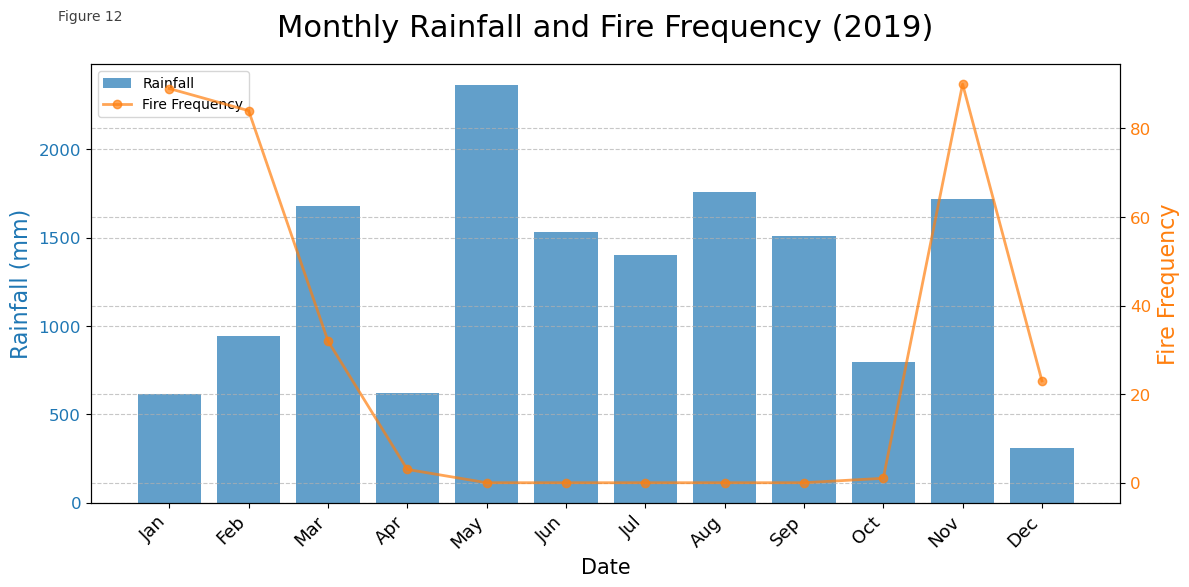

In [39]:
# Aggregate data monthly
monthly_data = combined_df.resample('ME').sum()
print(monthly_data)

# Create monthly labels
monthly_labels = monthly_data.index.strftime('%b')

# Plot monthly rainfall and fire frequency time series
fig, ax1 = plt.subplots(figsize=(12, 6))

# Colors
rainfall_color = '#1f77b4'  # Blue color for rainfall
fire_frequency_color = '#ff7f0e'  # Orange color for fire frequency

# Plot rainfall as bar chart
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Rainfall (mm)', color=rainfall_color, fontsize=16)
ax1.bar(monthly_labels, monthly_data['Rainfall amount (millimetres)'], color=rainfall_color, alpha=0.7, label='Rainfall', align='center')
ax1.tick_params(axis='y', labelcolor=rainfall_color, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot fire frequency as line chart
ax2 = ax1.twinx()
ax2.set_ylabel('Fire Frequency', color=fire_frequency_color, fontsize=16)
ax2.plot(monthly_labels, monthly_data['FireFrequency'], color=fire_frequency_color,alpha=0.7, marker='o', label='Fire Frequency', linestyle='-', linewidth=2)
ax2.tick_params(axis='y', labelcolor=fire_frequency_color, labelsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Set x-axis labels
ax1.set_xticks(np.arange(len(monthly_labels)))
ax1.set_xticklabels(monthly_labels, rotation=45, ha='right', fontsize=13)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Add title
plt.title('Monthly Rainfall and Fire Frequency (2019)', fontsize=22, pad=20)

plt.annotate(f'Figure 12', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0, 1.1), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

# Adjust layout
fig.tight_layout()
plt.show()

<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Monthly Rainfall and Fire Frequency (2019):</strong>
    <br>
    The figure 12 illustrates the relationship between monthly rainfall and fire frequency in the Gippsland region for the year 2019.
    <ul>
        <li><strong>Rainfall (Blue Bars):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The blue bars represent the total monthly rainfall measured in millimeters. Rainfall exhibits variability throughout the year, with the highest rainfall recorded in May and the lowest in April and December. Significant rainfall is also observed in March, June, and September.
        </p>
        
<li><strong>Fire Frequency (Orange Line):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The orange line indicates the monthly fire frequency. Fire incidents are most frequent in November, followed by December. From January to October, the number of fire incidents remains relatively low, with nearly no fires occurring from April to October.
        </p>
    </ul>
    <p style="margin-right:60px; line-height: 1.5;">
    Overall, the plot reveals an inverse relationship between rainfall and fire frequency. During months with high rainfall (e.g., March to June), the fire frequency is low. Conversely, during months with lower rainfall (e.g., November and December), the fire frequency significantly increases. This pattern highlights the critical role of rainfall in mitigating fire risks, with higher precipitation contributing to reduced fire incidents.
    </p>
</div>



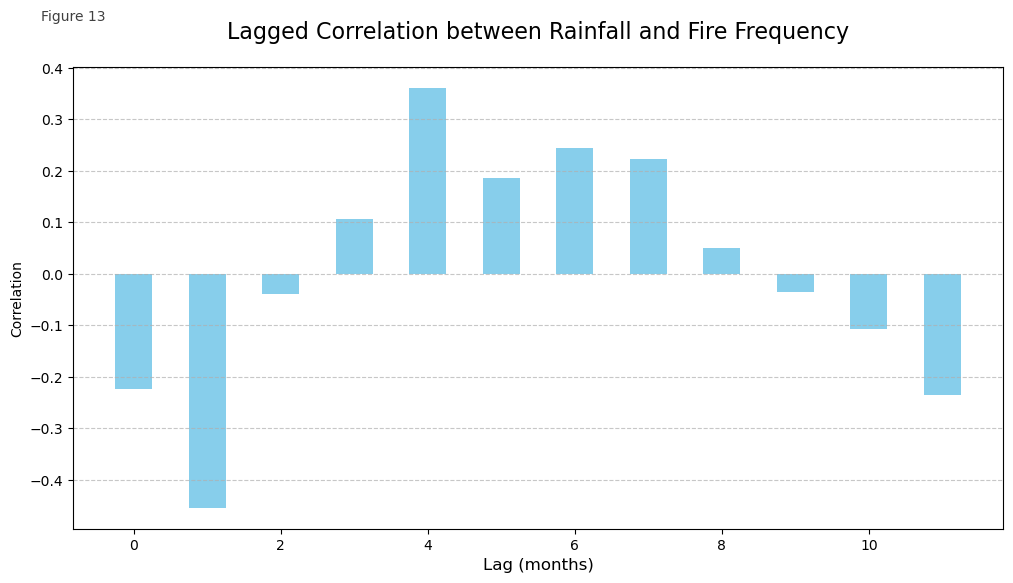

In [40]:
# Calculate lagged correlation
lagged_correlation = ccf(monthly_data['Rainfall amount (millimetres)'], monthly_data['FireFrequency'], adjusted=False)

# Plot lagged correlation
lags = np.arange(len(lagged_correlation))

plt.figure(figsize=(12, 6))
plt.bar(lags, lagged_correlation, width=0.5, color='skyblue')
plt.xlabel('Lag (months)', fontsize=12)
plt.ylabel('Correlation')
plt.title('Lagged Correlation between Rainfall and Fire Frequency', fontsize=16, pad=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.annotate(f'Figure 13', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0, 1.1), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

plt.show()


<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Correlation between Rainfall and Fire Frequency:</strong>
    <br>
    The figure 13 illustrates the lagged correlation between rainfall and fire frequency over a 12-month period in the Gippsland region for the year 2019.
    <ul>
        <li><strong>Positive Correlation at 4 Months Lag:</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        There is a significant positive correlation between rainfall and fire frequency with a lag of 4 months. This indicates that an increase in rainfall four months prior is associated with an increase in the current fire frequency. This could be due to the fact that higher rainfall promotes vegetation growth, which subsequently increases the amount of fuel available for fires after the vegetation dries out.
        </p>
        
<li><strong>Negative Correlation at 2 Months Lag:</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        There is a significant negative correlation between rainfall and fire frequency with a lag of 2 months. This suggests that higher rainfall two months prior tends to decrease the current fire frequency. The increased moisture content in the environment and vegetation likely reduces the likelihood of fire occurrences.
        </p>
        
<li><strong>Other Lag Periods:</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The other lag periods show weaker correlations, indicating that rainfall has a less significant impact on fire frequency at these intervals. This suggests that the effect of rainfall on fire frequency is more pronounced at specific lag periods (2 and 4 months) rather than uniformly affecting fire frequency across all lag periods.
        </p>
    </ul>
    <p style="margin-right:60px; line-height: 1.5;">
    Overall, the analysis of lagged correlations highlights the complex relationship between rainfall and fire frequency. The findings suggest that both recent and earlier rainfall can influence fire frequency, but in different ways. Understanding these patterns can help in predicting fire risks and improving fire management strategies.
    </p>
</div>

In [41]:
# Set a low rainfall threshold, assumed to be the 25th percentile of rainfall
threshold = monthly_data['Rainfall amount (millimetres)'].quantile(0.25)

# Identify low rainfall periods
low_rainfall_periods = monthly_data[monthly_data['Rainfall amount (millimetres)'] <= threshold]
high_rainfall_periods = monthly_data[monthly_data['Rainfall amount (millimetres)'] > threshold]


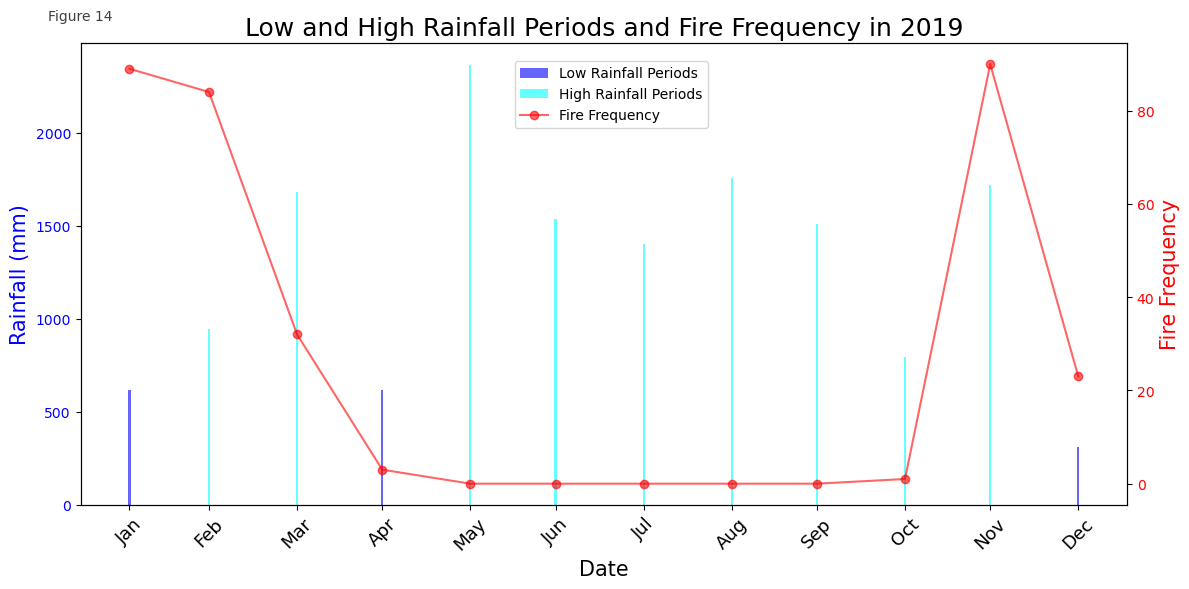

In [42]:

# Plot the chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create monthly labels
monthly_labels = monthly_data.index.strftime('%b')

# Plot rainfall for low and high rainfall periods
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Rainfall (mm)', color='blue', fontsize=15)
ax1.bar(low_rainfall_periods.index, low_rainfall_periods['Rainfall amount (millimetres)'], color='blue', alpha=0.6, label='Low Rainfall Periods')
ax1.bar(high_rainfall_periods.index, high_rainfall_periods['Rainfall amount (millimetres)'], color='cyan', alpha=0.6, label='High Rainfall Periods')
ax1.tick_params(axis='y', labelcolor='blue')

# Add fire frequency to the right Y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Fire Frequency', color='red', fontsize=15)
ax2.plot(monthly_data.index, monthly_data['FireFrequency'], color='red',alpha=0.6, marker='o', label='Fire Frequency')
ax2.tick_params(axis='y', labelcolor='red')

# Set x-axis ticks and labels
ax1.set_xticks(monthly_data.index)
ax1.set_xticklabels(monthly_labels, rotation=45, fontsize=13)

# Set legend
fig.legend(loc='upper right', bbox_to_anchor=(0.6,0.9))

plt.title('Low and High Rainfall Periods and Fire Frequency in 2019', fontsize=18)

plt.annotate(f'Figure 14', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0, 1.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

fig.tight_layout()
plt.show()



<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Low and High Rainfall Periods and Fire Frequency:</strong>
    <br>
    The figure 14 displays the relationship between low and high rainfall periods and fire frequency in the Gippsland region for the year 2019. The classification of low and high rainfall periods is based on the 25th percentile of the monthly rainfall.
    <ul>
        <li><strong>Low Rainfall Periods (Blue Bars):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The blue bars represent the months with low rainfall, defined as the months where the total rainfall is at or below the 25th percentile (approximately 497.03 mm). These periods include January, April, and December. The fire frequency (red line) during these months is notably high, particularly in November and December, indicating that low rainfall periods are associated with higher fire frequencies.
        </p>
        
<li><strong>High Rainfall Periods (Cyan Bars):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The cyan bars represent the months with high rainfall, where the total monthly rainfall exceeds the 25th percentile. These periods include February, March, May, June, July, August, September, and October. The fire frequency during these high rainfall months is generally low, demonstrating an inverse relationship between rainfall and fire frequency.
        </p>
    </ul>
    <p style="margin-right:60px; line-height: 1.5;">
    Overall, the plot illustrates that months with lower rainfall tend to have higher fire frequencies, while months with higher rainfall are associated with lower fire frequencies. This pattern underscores the significant role of rainfall in influencing fire risks, with increased precipitation helping to mitigate fire occurrences.
    </p>
</div>



## 3.3 Temperature

### 3.3.1 Heatwave Analysis

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Heatwave Analysis Overview</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        The heatwave analysis aims to investigate the impact of prolonged periods of high temperatures, known as heatwaves, on fire occurrence and severity. Heatwaves are defined as periods of consecutive days where temperatures exceed a specific threshold. This analysis will help understand how extreme temperature events influence the likelihood of bushfires.
    </p>
</div>

In [43]:
temperature_df = pd.read_csv('data/combined_temperature_file.csv')

# Construct the date
temperature_df['Date'] = pd.to_datetime(temperature_df[['Year', 'Month', 'Day']])

# Remove invalid values
temperature_df.dropna(subset=['Maximum temperature (Degree C)'], inplace=True)
temperature_df = temperature_df[temperature_df['Date'].dt.year == 2019]

# Ensure data is sorted in chronological order
temperature_df = temperature_df.sort_values('Date')
temperature_df.set_index('Date', inplace=True)


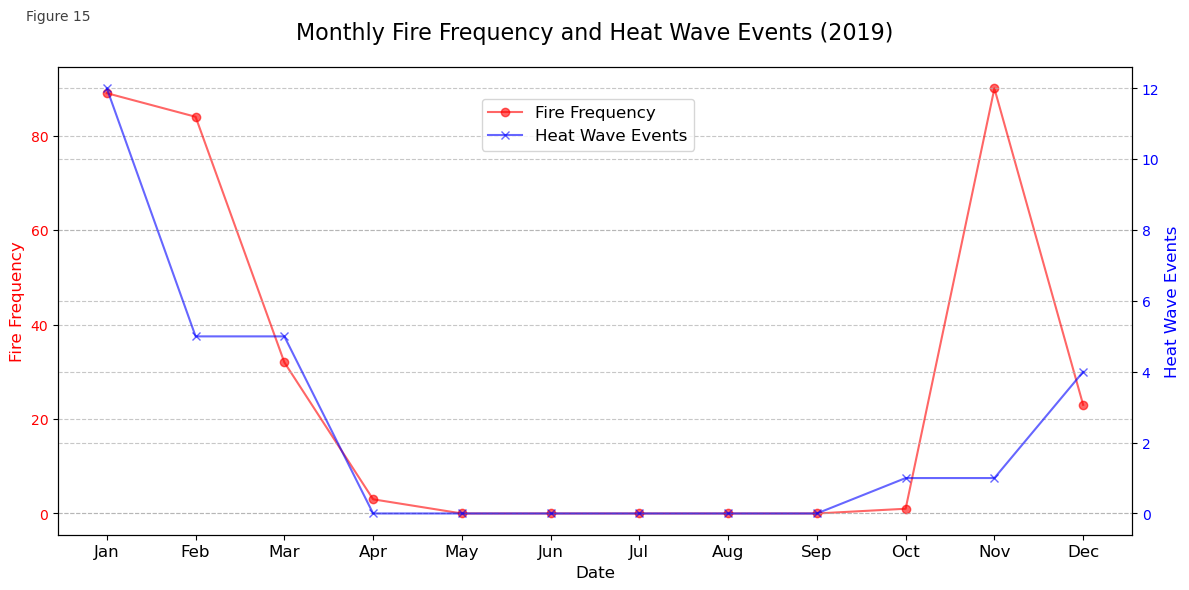

In [44]:


# Ensure temperature data is numeric and convert non-numeric data to NaN
temperature_df['Maximum temperature (Degree C)'] = pd.to_numeric(temperature_df['Maximum temperature (Degree C)'], errors='coerce')

# Aggregate by date, selecting the daily average temperature
daily_mean_temp = temperature_df['Maximum temperature (Degree C)'].resample('D').mean()

# Create a new DataFrame for further processing
daily_mean_temp_df = pd.DataFrame(daily_mean_temp)

# Define the threshold and consecutive days for a heatwave
heat_wave_threshold = 25  # Temperature threshold
heat_wave_days = 3  # Consecutive days of 3, effectively 4 days

# Calculate consecutive high-temperature days
daily_mean_temp_df['HeatWave'] = (daily_mean_temp_df['Maximum temperature (Degree C)'] > heat_wave_threshold).astype(int)
daily_mean_temp_df['HeatWaveStreak'] = daily_mean_temp_df['HeatWave'] * (daily_mean_temp_df['HeatWave'].groupby((daily_mean_temp_df['HeatWave'] != daily_mean_temp_df['HeatWave'].shift()).cumsum()).cumcount() + 1)

# Identify days exceeding the heatwave threshold
daily_mean_temp_df['IsHeatWave'] = (daily_mean_temp_df['HeatWaveStreak'] >= heat_wave_days).astype(int)

# Merge fire frequency and temperature data
combined_df = pd.concat([fire_frequency_daily, rainfall_daily['Rainfall amount (millimetres)'], daily_mean_temp_df['IsHeatWave']], axis=1)
combined_df = combined_df.fillna(0)  # Fill missing values

# Conduct statistical analysis and visualization
# Calculate monthly fire frequency and heatwave events
monthly_data = combined_df.resample('ME').sum()
monthly_data['HeatWaveEvents'] = monthly_data['IsHeatWave']

# Visualize analysis results
fig, ax1 = plt.subplots(figsize=(12, 6))
monthly_labels = monthly_data.index.strftime('%b')

# Plot fire frequency and heatwave events
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Fire Frequency', color='red', fontsize=12)
ax1.plot(monthly_labels, monthly_data['FireFrequency'], color='red', alpha=0.6, marker='o', label='Fire Frequency')
ax1.tick_params(axis='y', labelcolor='red')
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.set_ylabel('Heat Wave Events', color='blue', fontsize=12)
ax2.plot(monthly_labels, monthly_data['HeatWaveEvents'], color='blue', alpha=0.6, marker='x', label='Heat Wave Events')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='x', labelsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=12, bbox_to_anchor=(0.6,0.95))

# Add title
plt.title('Monthly Fire Frequency and Heat Wave Events (2019)', fontsize=16, pad=20)

plt.annotate(f'Figure 15', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0, 1.1), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

# Adjust layout
fig.tight_layout()
plt.show()



<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Summary of Monthly Fire Frequency and Heat Wave Events (2019):</strong>
    <br>
    The figure 15 presents the relationship between monthly fire frequency and heat wave events in the Gippsland region for the year 2019. The analysis considers days with consecutive high temperatures, defined as "heat wave days," and aggregates these into monthly "Heat Wave Events."
    <ul>
        <li><strong>Heat Wave Days:</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        Heat wave days are identified based on a temperature threshold of 25°C. A heat wave event is defined as a period of at least 3 consecutive days where the daily maximum temperature exceeds this threshold. This method helps in understanding prolonged periods of high temperatures and their potential impact on fire frequency.
        </p>
        
<li><strong>Heat Wave Events:</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        Heat Wave Events represent the total count of heat wave days aggregated on a monthly basis. This metric provides a summary of the frequency and duration of heat waves within each month.
        </p>
        
<li><strong>Fire Frequency (Red Line):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The red line on the plot represents the monthly fire frequency. Fire incidents are highest in January, February, and November, with a noticeable peak in November. These periods coincide with higher counts of heat wave events.
        </p>
        
<li><strong>Heat Wave Events (Blue Line):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The blue line illustrates the monthly heat wave events. Heat wave events are most frequent in January, February, and November, which aligns with the periods of high fire frequency. The correlation between heat wave events and fire frequency suggests that prolonged periods of high temperatures significantly contribute to the occurrence of fires.
        </p>
    </ul>
    <p style="margin-right:60px; line-height: 1.5;">
    Overall, the plot highlights the relationship between heat wave events and fire frequency. Months with a higher number of heat wave events tend to have increased fire frequency, indicating that sustained high temperatures play a critical role in fire risk. Understanding this relationship can aid in better predicting fire occurrences and implementing effective fire management strategies.
    </p>
</div>





### 3.3.2 Extreme Value Analysis

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Extreme Value Analysis Overview</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        The aim of this section is to identify extreme temperature events and analyze their correlation with major bushfires. Extreme temperature events, characterized by unusually high temperatures, can significantly contribute to the risk and intensity of bushfires. By analyzing these extreme temperature events, we can gain insights into their impact on major bushfire occurrences.
    </p>
</div>

In [45]:
daily_max_temp = temperature_df['Maximum temperature (Degree C)'].resample('D').max()

# Create a new DataFrame for further processing
daily_max_temp_df = pd.DataFrame(daily_max_temp)

# Define the threshold for extreme temperature
extreme_temp_threshold = 35  # Extreme temperature threshold

# Mark extreme temperature events
daily_max_temp_df['ExtremeTempEvent'] = (daily_max_temp_df['Maximum temperature (Degree C)'] > extreme_temp_threshold).astype(int)

# Merge fire frequency and extreme temperature event data
combined_extreme_df = pd.concat([fire_frequency_daily, daily_max_temp_df['ExtremeTempEvent']], axis=1)
combined_extreme_df = combined_extreme_df.fillna(0)  # Fill missing values

# Mark major bushfire events
major_fire_threshold = 5  # Threshold for major bushfire frequency
combined_extreme_df['MajorFireEvent'] = (combined_extreme_df['FireFrequency'] > major_fire_threshold).astype(int)

# Calculate correlation
correlation = combined_extreme_df[['ExtremeTempEvent', 'MajorFireEvent']].corr().iloc[0, 1]
print(f"Correlation between Extreme Temperature Events and Major Fire Events: {correlation}")


Correlation between Extreme Temperature Events and Major Fire Events: 0.330321973089984


<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Correlation between Extreme Temperature Events and Major Fire Events:</strong>
    <br>
    The correlation analysis between extreme temperature events and major fire events in the Gippsland region for the year 2019 yielded a correlation coefficient of 0.3303. This positive correlation suggests the following insights:
    <ul>
        <li><strong>Definition of Extreme Temperature Events:</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        Extreme temperature events are defined as days when the maximum daily temperature exceeds a predefined threshold, which in this analysis is set to 35°C. These events are significant because they represent periods of unusually high temperatures that can increase fire risk.
        </p>
        
<li><strong>Definition of Major Fire Events:</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        Major fire events are defined as days when the fire frequency exceeds a certain threshold, indicating a significant number of fire incidents. In this analysis, a major fire event is considered to occur when there are more than five fire incidents in a single day.
        </p>
        
<li><strong>Correlation Analysis:</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The correlation coefficient of 0.3303 indicates a moderate positive relationship between extreme temperature events and major fire events. This means that as the number of extreme temperature events increases, the likelihood of major fire events also tends to increase. Although the correlation is not very strong, it is statistically significant and highlights the impact of extreme temperatures on fire activity.
        </p>
    </ul>
    <p style="margin-right:60px; line-height: 1.5;">
    Overall, the analysis suggests that extreme temperature events play a crucial role in the occurrence of major fire events. These findings emphasize the importance of monitoring and managing extreme temperature conditions to mitigate the risk of significant fire outbreaks. Understanding this relationship can help in developing effective fire prevention and response strategies, particularly during periods of extreme heat.
    </p>
</div>


## 3.4 Fuel Moisture Content

### 3.4.1 Live Fuel Moisture Content

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Live Fuel Moisture Content Overview</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        The live fuel moisture is basically the ratio of mass of water within the fuel to oven-dry weight of fuel (Deb et al., 2020).  It is calculated from the Landsat 8/9 satellite images, following the approach of Caccamo et al. (2012). In order to calculate the live fuel moisture, first the visible atmospherically resistant index (VARI) is calculated from the three bands (band2: blue, band3: green, band4: red) using the approach of Gitelson et al. (2002) and is given in equation [1].
        <p style="margin-right:60px; line-height: 1.5;">
        VARI = (band 3 - band 4) / (band 3 + band 4 - band 2) <span style="float: right;">[1]</span>
        </p>
        Post calculation of VARI, live fuel moisture is calculated using the equation [2].
        <p style="margin-right:60px; line-height: 1.5;">
        Live FM (%) = A x e<sup>B x VARI <span style="float: right;">[2]</span>
        </p>
        <p style="margin-right:60px; line-height: 1.5;">
        where Live FM is live fuel moisture in percentage and A and B are constants. The above equation needs to be calibrated. An exclusively study over the southeastern Australia and calibrated A and B parameters as 52.51 and 1.36, respectively.
        </p>
    </p>
</div>

In [46]:
## Loading Landsat 8/9 raster
## Part 1 - prepare the file name of each raster
## -----
landsat_path = 'data/LANDSAT'

landsat_dir = os.listdir(landsat_path)
landsat_dir = [dir for dir in landsat_dir if dir.startswith("area")]

band2_blue = []; band3_green = []; band4_red = []

## Pushing the file path of each band into their classified list,
## to help combination work (i.e., merging images)
for area in sorted(landsat_dir):
    file_path = os.path.join(landsat_path, area)
    for root, dirs, files in os.walk(file_path):
        for band in files:
            if band.endswith("B2.TIF"): band2_blue.append(os.path.join(file_path, band))
            if band.endswith("B3.TIF"): band3_green.append(os.path.join(file_path, band))
            if band.endswith("B4.TIF"): band4_red.append(os.path.join(file_path, band))

print(band2_blue)
print(band3_green)
print(band4_red)

['data/LANDSAT/areaA_19_10_28/B2.TIF', 'data/LANDSAT/areaB_19_10_19/B2.TIF', 'data/LANDSAT/areaC_19_09_25/B2.TIF', 'data/LANDSAT/areaD_19_09_17/B2.TIF', 'data/LANDSAT/areaE_19_09_17/B2.TIF', 'data/LANDSAT/areaF_19_08_24/B2.TIF', 'data/LANDSAT/areaG_19_08_24/B2.TIF']
['data/LANDSAT/areaA_19_10_28/B3.TIF', 'data/LANDSAT/areaB_19_10_19/B3.TIF', 'data/LANDSAT/areaC_19_09_25/B3.TIF', 'data/LANDSAT/areaD_19_09_17/B3.TIF', 'data/LANDSAT/areaE_19_09_17/B3.TIF', 'data/LANDSAT/areaF_19_08_24/B3.TIF', 'data/LANDSAT/areaG_19_08_24/B3.TIF']
['data/LANDSAT/areaA_19_10_28/B4.TIF', 'data/LANDSAT/areaB_19_10_19/B4.TIF', 'data/LANDSAT/areaC_19_09_25/B4.TIF', 'data/LANDSAT/areaD_19_09_17/B4.TIF', 'data/LANDSAT/areaE_19_09_17/B4.TIF', 'data/LANDSAT/areaF_19_08_24/B4.TIF', 'data/LANDSAT/areaG_19_08_24/B4.TIF']


In [47]:
## Loading Landsat 8/9 raster
## Part 2 - define a function to merge rasters
## the reason is our study area Gippsland can not be cover by one satellite images
## thus, multiple images should be loaded and merged
from rasterio.merge import merge

def merge_imgaes(image_list, band_type):
    ''' no return type, but create a merged satellite images and store it in local file
        ----- 
        Parameter
            image_list: a list contains all the images waiting to merge
            band_type: a string, eg: blue, green, red
        -----
    '''
    band_list = []; merged_data = None; out_transform = None
    for band_file in image_list:
        band = rasterio.open(band_file, 'r')
        band_list.insert(0, band)
    
    merged_data, out_transform = merge(band_list, method='last')

    # Update the metadata with the new dimensions, transform, and CRS
    out_meta = band.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": merged_data.shape[1],
        "width": merged_data.shape[2],
        "transform": out_transform
    })

    output_path = './output'
    ## create folder if it does not exist
    if not os.path.exists(output_path):
        os.mkdir(output_path)

    # Write the merged TIFF to a new file
    with rasterio.open(f"{output_path}/{band_type}.TIF", "w", **out_meta) as dest:
        dest.write(merged_data)

    for band in band_list:
        band.close()

    print(f"Merged TIFF saved as: {output_path}/{band_type}.TIF")

In [48]:
## Loading Landsat 8/9 raster
## Part 3 - define a function to transform the merged raster into 'EPSG 7855' format
from rasterio.warp import calculate_default_transform, reproject, Resampling

def transform_images(name):
    ''' no return type, but create a transformed raster and store it in local file
        ----- 
        Parameter
            name: the path of a given raster
        -----
    '''

    # Open the source GeoTIFF file
    with rasterio.open(f'{name}.TIF') as src:

        # Define the target CRS (EPSG:7855)
        dst_crs = 'EPSG:7855'

        # Calculate the transform and dimensions for the new CRS
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)

        # Update the metadata with the new transform, CRS, and dimensions
        dst_meta = src.meta.copy()
        dst_meta.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create an output file and reproject the source data to the new CRS
        with rasterio.open(f'{name}_transformed.TIF', 'w', **dst_meta) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear
            )
            
    print(f"Transformed TIFF saved as: ./{name}_transformed.TIF")

In [49]:
## Loading Landsat 8/9 raster
## Part 4 - define a function to clip the raster into Gippsland area

from rasterio.mask import mask

def clip_images(name):
    ''' no return type, but create a clipped raster and store it in local file
        ----- 
        Parameter
            name: the path of a given raster
        -----
    '''

    ## Defining a raster grid
    gippsland_path = 'data/Gippsland.shp'
    gippsland_boundary = gpd.read_file(gippsland_path).to_crs(7855)

    # Open the raster file
    with rasterio.open(f'{name}_transformed.TIF') as src:
        # Clip the raster to the boundary
        clipped_raster, clipped_transform = rasterio.mask.mask(src, gippsland_boundary.geometry, crop=True)

        # Update the metadata for the clipped raster
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            'height': clipped_raster.shape[1],
            'width': clipped_raster.shape[2],
            'transform': clipped_transform
        })

        # Write the clipped raster to a new GeoTIFF file
        with rasterio.open(f'{name}_clipped.TIF', 'w', **clipped_meta) as ds:
            ds.write(clipped_raster)

    print(f"Clipped TIFF saved as: ./{name}_clipped.TIF")

In [50]:
## Loading Landsat 8/9 raster
## part 5 - processing the rasters

## band2 blue raster
merge_imgaes(band2_blue, 'blue')
transform_images('output/blue')
clip_images('output/blue')

Merged TIFF saved as: ./output/blue.TIF
Transformed TIFF saved as: ./output/blue_transformed.TIF
Clipped TIFF saved as: ./output/blue_clipped.TIF


In [51]:
## Loading Landsat 8/9 raster
## part 5 - processing the rasters

## band3 green raster
merge_imgaes(band3_green, 'green')
transform_images('output/green')
clip_images('output/green')

Merged TIFF saved as: ./output/green.TIF
Transformed TIFF saved as: ./output/green_transformed.TIF
Clipped TIFF saved as: ./output/green_clipped.TIF


In [52]:
## Loading Landsat 8/9 raster
## part 5 - processing the rasters

## band4 red raster
merge_imgaes(band4_red, 'red')
transform_images('output/red')
clip_images('output/red')

Merged TIFF saved as: ./output/red.TIF
Transformed TIFF saved as: ./output/red_transformed.TIF
Clipped TIFF saved as: ./output/red_clipped.TIF


In [53]:
## Preparing the Landsat images for plotting
## and later correlation analysis

def raster2np_array(band):
    ''' Returns a numpy array, it is projected from the raster
        -----
        Parameter
            band: (eg: blue, green and red)
        -----
    '''

    band_image = rasterio.open(f'./output/{band}_clipped.TIF', 'r')

    ## convert the nodata into nan
    nodata = band_image.nodata
    band = band_image.read().astype(np.float32)
    band[band == nodata] = np.NaN

    ## to convert Digital Numbers to actual reflectance
    ## referring the method in parctical 3.3
    band = band/10000

    ## clipping the reflectance values (caused by scattered clouds)
    ## referring the method in parctical 3.3
    pc = np.nanpercentile(band, 98) 
    band[band > pc] = pc

    band_image.close()

    return band

Band2_blue = raster2np_array('blue')
Band3_green = raster2np_array('green')
Band4_red = raster2np_array('red')

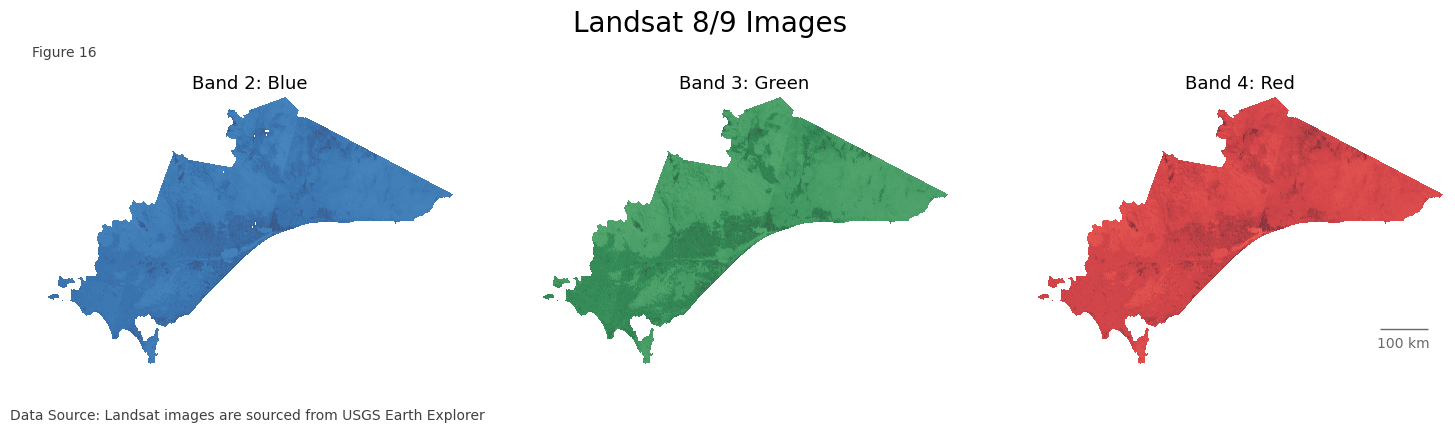

In [54]:
# Plotting Landsat 8/9 satellite images
## -----
fig, ax_list = plt.subplots(1, 3, figsize = (15, 10))
fig.suptitle('Landsat 8/9 Images', fontsize = 20, y=0.7)

## open a raster file to get its trandform information
## to help the plotting
demo = rasterio.open(f'./output/blue_clipped.TIF', 'r')

ax = ax_list[0]
im = rasterio.plot.show(Band2_blue, ax = ax, transform = demo.transform, cmap = 'Blues', alpha=0.8)
ax.set_title('Band 2: Blue', fontsize=13)
ax.axis('off')

ax = ax_list[1]
im = rasterio.plot.show(Band3_green, ax = ax, transform = demo.transform, cmap = 'Greens', alpha=0.8)
ax.set_title('Band 3: Green', fontsize=13)
ax.axis('off')

ax = ax_list[2]
im = rasterio.plot.show(Band4_red, ax = ax, transform = demo.transform, cmap = 'Reds', alpha=0.8)
ax.set_title('Band 4: Red', fontsize=13)
ax.axis('off')

demo.close()

ax_list[0].annotate(f'Data Source: Landsat images are sourced from USGS Earth Explorer ', xy=(0, 0), xycoords='axes fraction', xytext=(0.5, -0.2), textcoords='axes fraction', horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

fontprops = fm.FontProperties(size=10)
scalebar = AnchoredSizeBar(ax_list[2].transData,
                        50000, '100 km', 'lower right',
                        pad=0.1,
                        borderpad=1,
                        sep=5,
                        color='dimgray',
                        frameon=False,
                        size_vertical=1,
                        fontproperties=fontprops)
ax_list[2].add_artist(scalebar)

# x, y, arrow_length = 0.05, 0.5, 0.11
# ax_list[0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
#         arrowprops=dict(facecolor='snow', width=2.75, headwidth=7),
#         ha='center', va='center', fontsize=9,
#         xycoords=ax_list[0].transAxes)

ax_list[0].annotate(f'Figure 16', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.05, 1.15), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

plt.tight_layout()
plt.show()

<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Summary of Landsat 8/9 Images:</strong>
    <br>
    The figure 16 displays the merged images from Landsat 8/9 satellites, showing three different spectral bands: Blue (Band 2), Green (Band 3), and Red (Band 4). These images are sourced from the USGS Earth Explorer.
    <ul>
        <li><strong>Band 2: Blue</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The left panel shows the Blue band image, which highlights water bodies and helps in understanding coastal and aquatic ecosystems. This band is essential for analyzing water-related features in the study area.
        </p >
        
<li><strong>Band 3: Green</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The middle panel displays the Green band image, which is useful for assessing plant health and vegetation coverage. This band helps in identifying healthy vegetation, as plants reflect green light efficiently.
        </p>
        
<li><strong>Band 4: Red</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The right panel shows the Red band image, which is important for vegetation analysis and soil/plant differentiation. This band helps in identifying vegetation stress and mapping soil characteristics.
        </p>
    </ul>
   <p style="margin-right:60px; line-height: 1.5;">
    These composite images are created from seven smaller satellite images taken from August to October. The images provide a preliminary overview of the study area, which is used in the subsequent analysis of the Visible Atmospherically Resistant Index (VARI).
    </p >
</div>

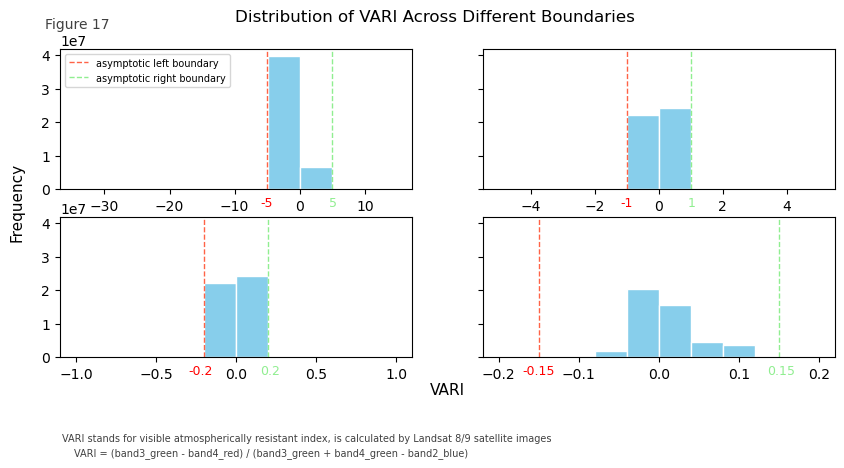

In [55]:
## Calculation of Live Fuel Moisture
## Part 1 - adjusting VARI values

## VARI stands for visible atmospherically resistant index
vari = (Band3_green - Band4_red) / (Band3_green + Band4_red - Band2_blue)

## The following figures show
## how we clipping the VARI outlier values
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10, 4), sharey = True)
fig.supxlabel("VARI", fontsize = 11, x=0.5125)
fig.supylabel("Frequency", fontsize = 11, x=0.075)
fig.suptitle('Distribution of VARI Across Different Boundaries', fontsize = 12)

axs[0][0].hist(vari.flatten(), color = 'skyblue', edgecolor = 'white')
axs[0][0].axvline(-5, color='tomato', linestyle='dashed', linewidth=1, label='asymptotic left boundary')
axs[0][0].axvline(5, color='lightgreen', linestyle='dashed', linewidth=1, label='asymptotic right boundary')
axs[0][0].legend(fontsize=7)
axs[0][0].annotate(f'-5', xy=(0, 0), xytext=(-6, -0.5e7),
            fontsize=9, color='red', ha='left')
axs[0][0].annotate(f'5', xy=(0, 0), xytext=(4.5, -0.5e7),
            fontsize=9, color='lightgreen', ha='left')


VARI_clipped = np.clip(vari, -5, 5)
axs[0][1].hist(VARI_clipped.flatten(), color = 'skyblue', edgecolor = 'white')
axs[0][1].axvline(-1, color='tomato', linestyle='dashed', linewidth=1, label='left bound: -1')
axs[0][1].axvline(1, color='lightgreen', linestyle='dashed', linewidth=1, label='right bound: 1')
axs[0][1].annotate(f'-1', xy=(0, 0), xytext=(-1.2, -0.5e7),
            fontsize=9, color='red', ha='left')
axs[0][1].annotate(f'1', xy=(0, 0), xytext=(0.9, -0.5e7),
            fontsize=9, color='lightgreen', ha='left')


VARI_clipped = np.clip(vari, -1, 1)
axs[1][0].hist(VARI_clipped.flatten(), color = 'skyblue', edgecolor = 'white')
axs[1][0].axvline(-0.20, color='tomato', linestyle='dashed', linewidth=1, label='left bound: -0.20')
axs[1][0].axvline(0.20, color='lightgreen', linestyle='dashed', linewidth=1, label='right bound: 0.20')
axs[1][0].annotate(f'-0.2', xy=(0, 0), xytext=(-0.3, -0.5e7),
            fontsize=9, color='red', ha='left')
axs[1][0].annotate(f'0.2', xy=(0, 0), xytext=(0.15, -0.5e7),
            fontsize=9, color='lightgreen', ha='left')
axs[1][0].annotate(f'VARI stands for visible atmospherically resistant index, is calculated by Landsat 8/9 satellite images', xy=(0, 0), xycoords='axes fraction', xytext=(0.7, -0.6), textcoords='axes fraction', horizontalalignment='center', fontsize=7, color='black', alpha=0.75)
axs[1][0].annotate(f'VARI = (band3_green - band4_red) / (band3_green + band4_green - band2_blue)', xy=(0, 0), xycoords='axes fraction', xytext=(0.6, -0.7), textcoords='axes fraction', horizontalalignment='center', fontsize=7, color='black', alpha=0.75)


VARI_clipped = np.clip(vari, -0.2, 0.2)
axs[1][1].hist(VARI_clipped.flatten(), color = 'skyblue', edgecolor = 'white')
axs[1][1].axvline(-0.15, color='tomato', linestyle='dashed', linewidth=1, label='left bound: -0.15')
axs[1][1].axvline(0.15, color='lightgreen', linestyle='dashed', linewidth=1, label='right bound: 0.15')
axs[1][1].annotate(f'-0.15', xy=(0, 0), xytext=(-0.17, -0.5e7),
            fontsize=9, color='red', ha='left')
axs[1][1].annotate(f'0.15', xy=(0, 0), xytext=(0.135, -0.5e7),
            fontsize=9, color='lightgreen', ha='left')

axs[0][0].annotate(f'Figure 17', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.05, 1.15), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

plt.show()

<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Summary of VARI Distribution Across Different Boundaries:</strong>
    <br>
    The figure displays the distribution of the Visible Atmospherically Resistant Index (VARI) across different boundaries using histograms. The VARI is calculated using Landsat 8/9 satellite images with the formula:
    <br><em>VARI = (band3_green - band4_red) / (band3_green + band4_green - band2_blue)</em>
    <p>The VARI values are derived from satellite images taken from three platforms, each consisting of seven smaller satellite images. These images were collected from August to October, resulting in a composite dataset with considerable outliers. Typically, VARI values should range between -1 and 1. However, the initial calculations produced values significantly outside this range, prompting further analysis through histograms to determine appropriate clipping boundaries.</p >
    <ul>
        <li><strong>Top Left Panel:</strong></li>
        <p>This panel shows the distribution of VARI values for a specific boundary. The x-axis represents VARI values, and the y-axis represents the frequency of occurrence. The red dashed line indicates the asymptotic left boundary, while the green dashed line indicates the asymptotic right boundary. The majority of VARI values are concentrated around 0, with fewer occurrences as values move away from the center.</p >
        
<li><strong>Top Right Panel:</strong></li>
        <p>This panel represents another boundary with a different VARI value range. Similarly, the red and green dashed lines indicate the asymptotic left and right boundaries, respectively. The VARI values are primarily distributed around 0 to 1.</p >
        
<li><strong>Bottom Left Panel:</strong></li>
        <p>This panel shows the VARI distribution for another boundary. The VARI values are concentrated around -0.5 to 0.5, with asymptotic boundaries at -0.2 and 0.2.</p >
        
<li><strong>Bottom Right Panel:</strong></li>
        <p>This panel displays the distribution of VARI values for a different boundary, with values ranging from -0.2 to 0.2. The asymptotic boundaries are marked at -0.15 and 0.15. The distribution is more spread out compared to the other panels.</p >
    </ul>
    <p>Overall, the figure illustrates how VARI values are distributed across different boundaries, highlighting the range and concentration of values within each boundary. After clipping the data to the range of -0.15 to 0.15, over 99% of the data points fell within this range, significantly reducing the impact of outliers and providing a clearer understanding of the vegetation index and its variability across different spatial regions.</p >
</div>

In [56]:
## Validation on the choosen clipping boundaries
## by calculating the percentiles

VARI_clipped = np.clip(vari, -0.15, 0.15)

text = ['1th percentile', '25th percentile', '50th percentile', '75th percentile', '99th percentile']

print('The distribution of VARI under the boundary between -0.15 and 0.15:')
for index, percentile in enumerate(np.nanpercentile(VARI_clipped, [1, 25, 50, 75, 99])):
    print('    {} {:.2f}'.format(text[index], percentile))

The distribution of VARI under the boundary between -0.15 and 0.15:
    1th percentile -0.06
    25th percentile -0.01
    50th percentile 0.00
    75th percentile 0.02
    99th percentile 0.12


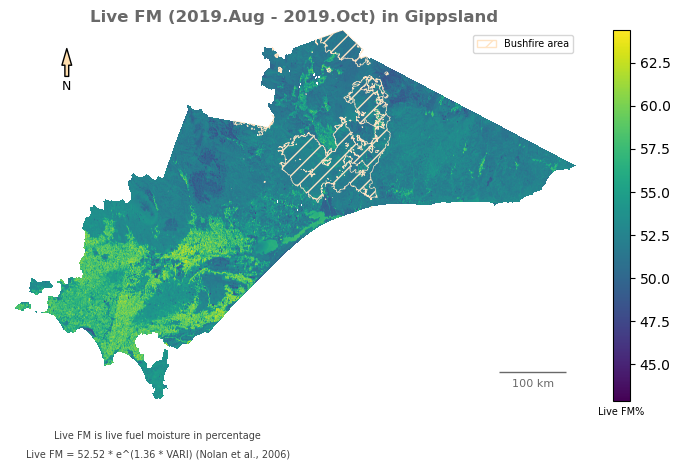

In [57]:
## Calculation of Live Fuel Moisture
## Part 2 - final calculation based on the equation
## and plotting this results

Live_fm = 52.51 * np.exp(1.36 * VARI_clipped)

## loading bushfire records 1st Nov 2019 - 31st Dec 2019
## since the landsat 8/9 images were generated between Aug 2019 - Oct 2019.
Fire_hist_gpd = gpd.read_file('data/FIRE.gdb')
Fire_19 = Fire_hist_gpd[(Fire_hist_gpd.START_DATE_INT >= 20191101) & (Fire_hist_gpd.START_DATE_INT <= 20191231)]
Fire_19 = gpd.clip(Fire_19, Gippsland_region_gdf[Gippsland_region_gdf.name == 'Gippsland'].geometry)
Fire_19 = Fire_19[Fire_19.FIRETYPE == 'BUSHFIRE'].reset_index(drop = True)


import matplotlib.font_manager as fm

fig, ax = plt.subplots(figsize = (8, 9))
ax.axis('off')

## open a raster file to get its trandform information
## to help the plotting
demo = rasterio.open(f'./output/blue_clipped.TIF', 'r')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.35)
cax.set_xlabel('Live FM%', loc='center', fontsize = 7)

im = rasterio.plot.show(Live_fm, ax = ax, transform = demo.transform)
im = im.get_images()[0]

Fire_19.plot(ax=ax, facecolor='none', edgecolor='bisque', linewidth=0.5, hatch='//')

fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_title('Live FM (2019.Aug - 2019.Oct) in Gippsland', color='dimgray', fontweight='bold')

x, y, arrow_length = 0.1, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='navajowhite', width=2.75, headwidth=7),
            ha='center', va='center', fontsize=9,
            xycoords=ax.transAxes)

ax.annotate(f'Live FM is live fuel moisture in percentage', xy=(0, 0), xycoords='axes fraction', xytext=(0.26, -0.1), textcoords='axes fraction', horizontalalignment='center', fontsize=7, color='black', alpha=0.75)
ax.annotate(f'Live FM = 52.52 * e^(1.36 * VARI) (Nolan et al., 2006)', xy=(0, 0), xycoords='axes fraction', xytext=(0.26, -0.15), textcoords='axes fraction', horizontalalignment='center', fontsize=7, color='black', alpha=0.75)

fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(ax.transData,
                        50000, '100 km', 'lower right',
                        pad=0.1,
                        borderpad=1,
                        sep=5,
                        color='dimgray',
                        frameon=False,
                        size_vertical=1,
                        fontproperties=fontprops)
ax.add_artist(scalebar)

# Create a custom legend handle
legend_handle = Patch(facecolor='none', edgecolor='bisque', hatch='//', label='Bushfire area')

# Add the legend to the plot
ax.legend(handles=[legend_handle], fontsize=7)

demo.close()

# ax.annotate(f'Figure 18', xy=(0.5, 0.5), xycoords='axes fraction', 
#             xytext=(0.05, 1), textcoords='axes fraction',
#             horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

plt.savefig('Figure18.png', format='png', bbox_inches='tight')

plt.show()

<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Summary of Live Fuel Moisture (Live FM) in Gippsland (August - October 2019):</strong>
    <br>
    The map displays the live fuel moisture (Live FM) percentage in Gippsland from August to October 2019. The Live FM is calculated using the formula:
    <br><em>Live FM = 52.52 * e^(1.36 * VARI)</em> (Nolan et al., 2006)
    <p>It is observed that the western region of Gippsland has slightly higher live fuel moisture compared to other areas. However, the rest of the region shows little variation in moisture content, indicating a relatively uniform distribution of live fuel moisture across these areas.</p >
</div>

In [58]:
## Live fuel moisture content - Factor Analysis
## Part 1 - aligning the dimension of Live Fuel Moisture numpy array with the fire occurrence numpy array
## aims to reduce computational load, resampling the high dimensional Live Fuel Moisture raster to lower dimension

## 3D to 2D
Live_fm = np.squeeze(Live_fm)

## open a raster file to get its trandform information
## to help the raster writing
demo = rasterio.open(f'./output/blue_clipped.TIF', 'r')

## write the Live Fuel Moisture numpy array into a raster
with rasterio.open(
        'output/2019_Live_FM.tif', 
        'w',
        driver='GTiff', 
        height=Live_fm.shape[0], 
        width=Live_fm.shape[1],
        count=1, 
        dtype=Live_fm.dtype,
        crs='EPSG:7855',
        transform=demo.transform) as dst:
    dst.write(Live_fm, 1)

demo.close()

## resampling the high dimensional raster Live Fuel Moisture (30m * 30m)
## to lower dimensional one (1000m * 1000m)
## since this can hugely reduce the computational load
out_res = (1000, 1000)
Live_FM_TIF = rasterio.open('output/2019_Live_FM.tif', 'r')
# use rasterio.wrap.calculate_default_transform() to 
# construct a mathematical transformation between the two coordinate systems.
# calculating transform array and shape of reprojected raster
out_transform, out_width, out_height = rasterio.warp.calculate_default_transform(
														Live_FM_TIF.crs,
                                                        Live_FM_TIF.crs,
                                                        Live_fm.shape[1],
                                                        Live_fm.shape[0], 
                                                        resolution = out_res,
                                                        *Live_FM_TIF.bounds)


# -----
out_profile = Live_FM_TIF.profile
# updating destination raster metadata
out_profile['height'] = out_height - 1
out_profile['width'] = out_width - 1
out_profile['crs'] = Live_FM_TIF.crs
out_profile['transform'] = out_transform


# defining output path and filename
out_raster_file = './output/2019_Live_FM_res_1000.tif'


## write the Live Fuel Moisture raster into lower resolution (1000m * 1000m)
with rasterio.open(out_raster_file, 'w', **out_profile, compress='DEFLATE') as ds_out:
    rasterio.warp.reproject(source = rasterio.band(Live_FM_TIF, 1),
                            destination = rasterio.band(ds_out, 1),
                            src_crs = Live_FM_TIF.crs,
                            dst_crs = ds_out.crs,
                            dst_resolution = out_res,
                            # use bilinear resampling, suitable for continuous (not ordinal or nominal) data
                            resampling = Resampling.bilinear)

print('The new live fuel moisture raster has been prepared in resolution 1000m * 1000m.')

The new live fuel moisture raster has been prepared in resolution 1000m * 1000m.


In [59]:
## Live fuel moisture content - Factor Analysis
## Part 1 - aligning the dimension of Live Fuel Moisture numpy array with the fire occurrence numpy array
## calculating the fire occurrence in each 1000m * 1000m area

from shapely.geometry import box

## -----
## Defining a raster grid
gippsland_boundary_path = 'data/Gippsland.shp'
Gippsland_boundary = gpd.read_file(gippsland_boundary_path).to_crs(7855)
Gippsland_bounds = Gippsland_boundary.bounds

minX = Gippsland_bounds.minx.values[0]
minY = Gippsland_bounds.miny.values[0]
maxX = Gippsland_bounds.maxx.values[0]
maxY = Gippsland_bounds.maxy.values[0]

resolution = 1000 # cell size 1000m x 1000m
height = (maxY - minY) / resolution
width = (maxX - minX) / resolution

height = math.ceil(height) - 1
width = math.ceil(width) - 1

# Create an empty array to hold the density values
fire_occurrence = np.zeros((height, width))
## -----


## seting up an affine transformation,
## since this can help to transform the grid coordinates to a georeferenced raster grid
out_transform = Affine.translation(minX - resolution/2, maxY - resolution/2) * Affine.scale(resolution, -resolution)

## determine fire occurrence (boolean value) in a 1000m * 1000m area
for geom in Fire_19.geometry:
    # Get the bounding box of each fire polygon
    bounds = geom.bounds
    min_col = int((bounds[0] - minX) / resolution)
    max_col = int((bounds[2] - minX) / resolution)
    min_row = int((maxY - bounds[3]) / resolution)
    max_row = int((maxY - bounds[1]) / resolution)

    # Increment the density count in the corresponding cells
    for row in range(min_row, max_row + 1):
        for col in range(min_col, max_col + 1):
            if geom.intersects(box(minX + col * resolution, maxY - (row + 1) * resolution,
                                   minX + (col + 1) * resolution, maxY - row * resolution)):
                fire_occurrence[row, col] += 1


## Writing the fire occurrence numpy array into a raster
with rasterio.open(
        'output/2019_fire_density.tif', 
        'w',
        driver='GTiff', 
        height=fire_occurrence.shape[0], 
        width=fire_occurrence.shape[1],
        count=1, 
        dtype=fire_occurrence.dtype,
        crs='EPSG:7855',
        transform=out_transform) as dst:
    dst.write(fire_occurrence, 1)


## Clipping the fire occurrence raster into Gippsland area
with rasterio.open('output/2019_fire_density.tif', 'r') as ras:
    profile = ras.profile
    masked_ras, masked_ras_transform = rasterio.mask.mask(dataset = ras, 
                                                        shapes = Gippsland_boundary.geometry, 
                                                        nodata = np.NaN, 
                                                        crop = True)
    
    masked_ras_profile = profile.copy()
    masked_ras_profile['height'] = masked_ras.shape[1]
    masked_ras_profile['width'] = masked_ras.shape[2]
    masked_ras_profile['transform'] = masked_ras_transform
    
    with rasterio.open('output/2019_fire_density_clipped.tif', 'w', **masked_ras_profile) as ds_out:
        ds_out.write(masked_ras)

print('The fire occurrence raster has been prepared in resolution 1000m * 1000m.')

The fire occurrence raster has been prepared in resolution 1000m * 1000m.


In [60]:
## Live fuel moisture content - Factor Analysis
## Part 2 - Calculating the Correlation between live fuel moisture content and fire frequency

from scipy.stats import pearsonr

## loading live fuel moisture raster and fire occurrence raster (it contains the fire frequency data)
live_fm_res_1000 = rasterio.open('output/2019_Live_FM_res_1000.tif', 'r')
fire_occurrence = rasterio.open('output/2019_fire_density_clipped.tif', 'r')
Live_fm_res_1000 = live_fm_res_1000.read(1).astype('float64')
Fire_occurrence = fire_occurrence.read(1).astype('float64')

## replace the nan value
Live_fm_res_1000 = np.nan_to_num(Live_fm_res_1000, nan=-999)
Fire_occurrence = np.nan_to_num(Fire_occurrence, nan=-999)

## clipping these grids with nan value
## and make Live_fm numpy array and Fire_occurrence is consistent and aligned
mask = (Live_fm_res_1000 != -999) & (Fire_occurrence != -999)
Live_fm_res_1000_valid = Live_fm_res_1000[mask]
Fire_occurrence_valid = Fire_occurrence[mask]

## flattening
Live_fm_res_1000_flat = Live_fm_res_1000_valid.flatten()
Fire_occurrence_flat = Fire_occurrence_valid.flatten()

## calculating the coefficient between live fuel moisture content and fire frequency
live_fmc_cc, __ = pearsonr(Live_fm_res_1000_flat, Fire_occurrence_flat)

live_fm_res_1000.close()
fire_occurrence.close()

print(f'Correlation between live fuel moisture content and fire frequency is prepared.')

Correlation between live fuel moisture content and fire frequency is prepared.


In [61]:
## Live fuel moisture content - Factor Analysis
## Part 3 - Visualising the distribution of live fuel moisture content with fire areas and without fire areas
## prepare the data

Live_fm_res_1000 = rasterio.open('output/2019_Live_FM_res_1000.tif', 'r')
Fire_occurrence = rasterio.open('output/2019_fire_density_clipped.tif', 'r')

Live_fm_res_1000 = Live_fm_res_1000.read(1).astype('float64')
Fire_occurrence = Fire_occurrence.read(1).astype('float64')

fire_areas = Live_fm_res_1000[Fire_occurrence > 0]
fire_areas = fire_areas[~np.isnan(fire_areas)]
no_fire_areas = Live_fm_res_1000[Fire_occurrence == 0]
no_fire_areas = no_fire_areas[~np.isnan(no_fire_areas)]

print(f'The data of live fuel moisture content with fire areas and without fire areas is prepared')

The data of live fuel moisture content with fire areas and without fire areas is prepared


Correlation between live fuel moisture content and fire frequency: -0.1803


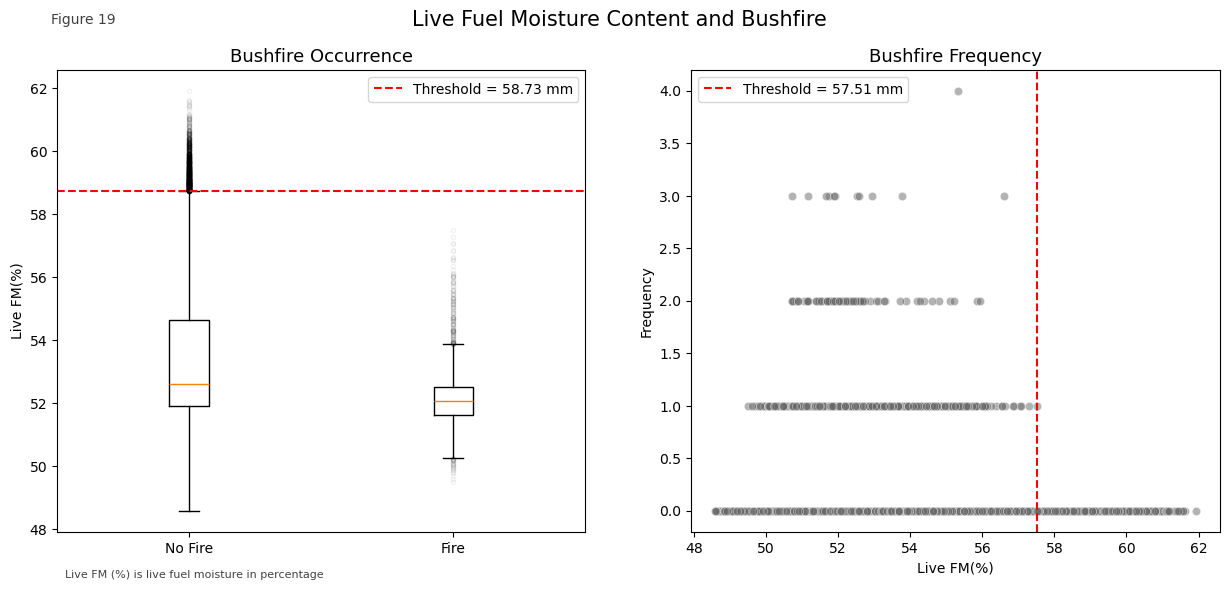

In [62]:
## Live fuel moisture content - Factor Analysis
## Part 4 - Plotting the results

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plt.suptitle('Live Fuel Moisture Content and Bushfire', fontsize=15)

## part A ##
## Calculating the threshold of live fuel moisture content
## that may cause bushfire
## method: find the upper bound of IQR
live_fmc = pd.Series(no_fire_areas).describe()
live_fmc_25 = live_fmc['25%']
live_fmc_75 = live_fmc['75%']
iqr = live_fmc_75 - live_fmc_25
upper_bound_iqr = live_fmc_75 + 1.5 * iqr

ax[0].boxplot([no_fire_areas, fire_areas], labels=['No Fire', 'Fire'], flierprops=dict(marker='.', color='lightgrey', alpha=0.05))
ax[0].axhline(upper_bound_iqr, color='r', linestyle='--', label=f'Threshold = {upper_bound_iqr:.2f} mm')
ax[0].set_title('Bushfire Occurrence', fontsize=13)
ax[0].set_ylabel('Live FM(%)')
ax[0].legend()
## ----- ##

## part B ##
# Find the maximum live mc at one fire occurrence
threshold = np.max(Live_fm_res_1000_flat[Fire_occurrence_flat == 1])

ax[1].scatter(Live_fm_res_1000_flat, Fire_occurrence_flat, alpha=0.5, edgecolors='w', linewidth=0.5, color='dimgrey')
ax[1].axvline(threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f} mm')
ax[1].set_title('Bushfire Frequency', fontsize=13)
ax[1].set_xlabel('Live FM(%)')
ax[1].set_ylabel('Frequency')
ax[1].legend()

print(f'Correlation between live fuel moisture content and fire frequency: {round(live_fmc_cc, 4)}')
ax[0].annotate(f'Live FM (%) is live fuel moisture in percentage', xy=(0, 0), xycoords='axes fraction', xytext=(0.26, -0.1), textcoords='axes fraction', horizontalalignment='center', fontsize=8, color='black', alpha=0.75)

ax[0].annotate(f'Figure 19', xy=(0.5, 0.5), xycoords='axes fraction', 
            xytext=(0.05, 1.1), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

# plt.savefig('Figure19.png', format='png', bbox_inches='tight')

## ----- ##
plt.show()

<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Summary of Live Fuel Moisture Content and Bushfire:</strong>
    <br>
    The correlation analysis between live fuel moisture content and bushfire frequency reveals a negative correlation, with a coefficient of approximately -0.18. This suggests that higher moisture content in live vegetation reduces the likelihood of ignition and subsequent fires. The figure 19 explores the relationship between live fuel moisture (live FM) content and bushfire occurrences and frequency.
    <ul>
        <li><strong>Bushfire Occurrence (Left Panel):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The boxplot on the left panel compares the distribution of live fuel moisture content between regions with bushfires and those without. An important threshold identified from the 2019 historical data indicates that when the live fuel moisture content exceeds 58.73%, no bushfires were recorded in those regions.
        </p >
        
<li><strong>Bushfire Frequency (Right Panel):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The scatter plot on the right panel provides a clearer illustration of the relationship between live fuel moisture content and bushfire frequency. It can be observed that regions with a live fuel moisture content above 57.51% did not experience any bushfires. This reinforces the finding that higher moisture content in vegetation significantly reduces the likelihood of bushfires.
        </p >
    </ul>
    <p style="margin-right:60px; line-height: 1.5;">
    In conclusion, while live fuel moisture content is a critical factor influencing bushfire occurrence.
    </p >
</div>

### 3.4.2 Dead Fuel Moisture Content

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Dead Fuel Moisture Content Overview</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        In this study, dead fuel moisture is calculated using semimechanistic model developed for Australia by de Dios et al. (2015) is employed in this study. The dead fuel moisture model is based on an exponential relationship among the dead fuel moisture and vapor pressure deficit. The model is given in Equation [3].
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        Dead FM (%) = 6:79 + 27:43e<sup>−1.05D</sup> <span style="float: right;">[3]</span>
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        where Dead FM is dead fuel moisture in percentage and D is vapor pressure deficit in kPa. D is calculated using the saturation vapor pressure (svp) in euqation [4] minus the actual vapor pressure (avp) in equation [5].
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        svp = 0.6108 x e<sup>(17.27 x T)/(T + 237.3)</sup> <span style="float: right;">[4]</span>
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        where T is the daily maximum temperature in degrees.
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        avp = svp x (RH / 100) <span style="float: right;">[5]</span>
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        where RH is the relavtive humidity at the highest temperature in percentage.
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
    The daily maximum temperature raster and the relative humidity at the highest temperature rasters were sourced from SILO Data Drill, the data were created on 31 Oct 2019.
    </p>
</div>

In [63]:
def raster_transform(in_file, out_file, res):
    ''' no return type, but create a transformed raster and store it in local file
        ----- 
        Parameter
            in_file: input raster name
            out_file: output raster name
            res: resolution
        -----
    '''
    out_res = (res, res)
    out_transform, out_width, out_height = rasterio.warp.calculate_default_transform(
                                                            in_file.crs,
                                                            'EPSG:7855',
                                                            in_file.width,
                                                            in_file.height, 
                                                            resolution = out_res,
                                                            *in_file.bounds)

    # -----
    out_profile = in_file.profile

    # updating destination raster metadata
    out_profile['height'] = out_height
    out_profile['width'] = out_width
    out_profile['crs'] = 'EPSG:7855'
    out_profile['transform'] = out_transform

    # defining output path and filename
    out_raster_file = f'./output/{out_file}_transformed.TIF'

    # while exporting the raster we need to change the mode to 'w' and provide raster 'profile' parameters
    # we also specify that the TIFF file should be compressed using the DEFLATE algorithm
    # deflate is a lossless data compression file format
    # use rasterio.warp.reproject() function to reproject the input raster to a new raster
    with rasterio.open(out_raster_file, 'w', **out_profile) as ds_out:
        rasterio.warp.reproject(source = rasterio.band(in_file, 1),
                                destination = rasterio.band(ds_out, 1),
                                src_crs = in_file.crs,
                                dst_crs = ds_out.crs,
                                dst_resolution = out_res,
                                # use bilinear resampling, suitable for continuous (not ordinal or nominal) data
                                resampling = Resampling.bilinear)
    
    print(f'Transformed TIFF saved as: {out_raster_file}')

In [64]:
## SILO Data Drill raster processing

## ----- ##
## load maximum temperature raster
max_temp_file = 'data/20191031.max_temp.TIF'
max_temp = rasterio.open(max_temp_file, 'r')
raster_transform(max_temp, 'max_temp', 1000)
clip_images('output/max_temp')

## load relative humidity raster at the maximum temperature moment
RH_path = 'data/20191031.rh_tmax.TIF'
RH = rasterio.open(RH_path, 'r')
raster_transform(RH, 'rh', 1000)
clip_images('output/rh')

Transformed TIFF saved as: ./output/max_temp_transformed.TIF
Clipped TIFF saved as: ./output/max_temp_clipped.TIF
Transformed TIFF saved as: ./output/rh_transformed.TIF
Clipped TIFF saved as: ./output/rh_clipped.TIF


In [65]:
## Calculation of Dead Fuel Moisture

## ----- ##
## Part A ##
## calculate the saturation vapor pressure (svp)
t = rasterio.open('./output/max_temp_clipped.TIF', 'r')
nodata = t.nodata
T = t.read(1)
T[T == nodata] = np.nan
svp = 0.611 * np.exp((17.27 * T)/(T + 237.3))

## Part B ##
## Calculating actual vapor pressure
rh = rasterio.open('./output/rh_clipped.TIF', 'r')
nodata = rh.nodata
RH = rh.read(1)
RH[RH == nodata] = np.nan
avp = svp * (RH / 100)

## Part C ##
## Calculating the vapor pressure deficit
vpd = svp - avp
## Calculating the dead fuel moisture content
dead_fm = 6.79 + 27.43 * np.exp(-1.05*vpd)

t.close()
rh.close()

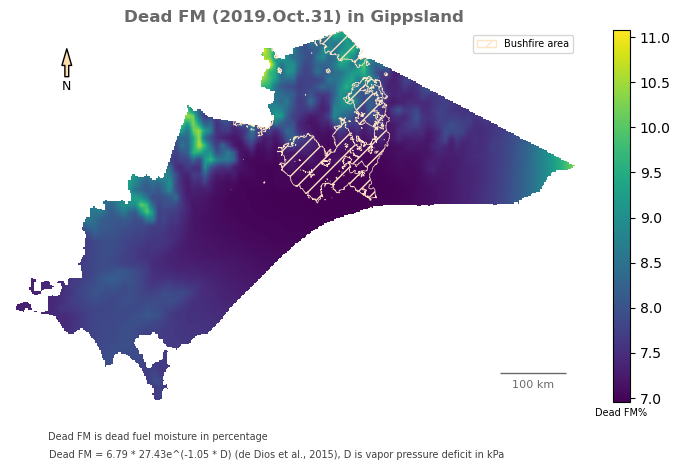

In [66]:
## Plotting the result

## ----- ##
fig, ax = plt.subplots(figsize = (8, 9))
ax.axis('off')

## open a raster file to get its trandform information
## to help the plotting
demo = rasterio.open('./output/rh_clipped.TIF', 'r')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.35)
cax.set_xlabel('Dead FM%', loc='center', fontsize = 7)

im = rasterio.plot.show(dead_fm, ax = ax, transform = demo.transform)
im = im.get_images()[0]

Fire_19.plot(ax=ax, facecolor='none', edgecolor='bisque', linewidth=0.5, hatch='//')

fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_title('Dead FM (2019.Oct.31) in Gippsland', color='dimgray', fontweight='bold')

x, y, arrow_length = 0.1, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='navajowhite', width=2.75, headwidth=7),
            ha='center', va='center', fontsize=9,
            xycoords=ax.transAxes)

ax.annotate(f'Dead FM is dead fuel moisture in percentage', xy=(0, 0), xycoords='axes fraction', xytext=(0.26, -0.1), textcoords='axes fraction', horizontalalignment='center', fontsize=7, color='black', alpha=0.75)
ax.annotate(f'Dead FM = 6.79 * 27.43e^(-1.05 * D) (de Dios et al., 2015), D is vapor pressure deficit in kPa', xy=(0, 0), xycoords='axes fraction', xytext=(0.47, -0.15), textcoords='axes fraction', horizontalalignment='center', fontsize=7, color='black', alpha=0.75)

fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(ax.transData,
                        50000, '100 km', 'lower right',
                        pad=0.1,
                        borderpad=1,
                        sep=5,
                        color='dimgray',
                        frameon=False,
                        size_vertical=1,
                        fontproperties=fontprops)
ax.add_artist(scalebar)

# Create a custom legend handle
legend_handle = Patch(facecolor='none', edgecolor='bisque', hatch='//', label='Bushfire area')

# Add the legend to the plot
ax.legend(handles=[legend_handle], fontsize=7)

demo.close()

# ax.annotate(f'Figure 20', xy=(0.5, 0.5), xycoords='axes fraction', 
#             xytext=(0.05, 1.1), textcoords='axes fraction',
#             horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

plt.savefig('Figure20.png', format='png', bbox_inches='tight')

plt.show()


<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Summary of Dead Fuel Moisture (Dead FM) in Gippsland (October 31, 2019):</strong>
    <br>
    The map displays the dead fuel moisture (Dead FM) percentage in Gippsland on October 31, 2019. The Dead FM is calculated using the formula:
    <br><em>Dead FM = 6.79 + 27.43e^(-1.05 * D)</em> (de Dios et al., 2015), where D is the vapor pressure deficit in kPa.
    <p>The map indicates varying levels of dead fuel moisture across the region. The western areas show slightly higher dead fuel moisture, whereas the rest of the region exhibits relatively uniform and lower moisture levels. The highlighted bushfire areas help in understanding the correlation between dead fuel moisture and fire risk.</p >
</div>

In [67]:
## Dead fuel moisture content - Factor Analysis
## Part 1 - Calculating the Correlation between dead fuel moisture content and fire frequency

from skimage.transform import resize

fire_occurrence = rasterio.open('output/2019_fire_density_clipped.tif', 'r')
Fire_occurrence = fire_occurrence.read(1).astype('float64')

# Resize the dead_fuel_moisture array
resized_dead_fm = resize(dead_fm, Fire_occurrence.shape, anti_aliasing=True)

# Flatten the arrays
dead_fm_flat = resized_dead_fm.flatten()
fire_occ_flat = Fire_occurrence.flatten()

# Create a mask to NaN, and inf values in fire_occurrence
mask = np.isfinite(fire_occ_flat) & np.isfinite(dead_fm_flat)
dead_fm_flat = dead_fm_flat[mask]
fire_occ_flat = fire_occ_flat[mask]

# Calculate Pearson correlation
dead_fm_cc, _ = pearsonr(dead_fm_flat, fire_occ_flat)
print(f'Correlation between dead fuel moisture content and fire frequency is prepared.')

Correlation between dead fuel moisture content and fire frequency is prepared.


In [68]:
## Dead fuel moisture content - Factor Analysis
## Part 2 - Visualising the distribution of dead fuel moisture content with fire areas and without fire areas
## prepare the data

no_fire_area = resized_dead_fm[Fire_occurrence == 0]
no_fire_area = no_fire_area[~np.isnan(no_fire_area)]
fire_area = resized_dead_fm[Fire_occurrence > 0]
fire_area = fire_area[~np.isnan(fire_area)]

print(f'The data of dead fuel moisture content with fire areas and without fire areas is prepared')

The data of dead fuel moisture content with fire areas and without fire areas is prepared


Correlation between live fuel moisture content and fire frequency: -0.0553


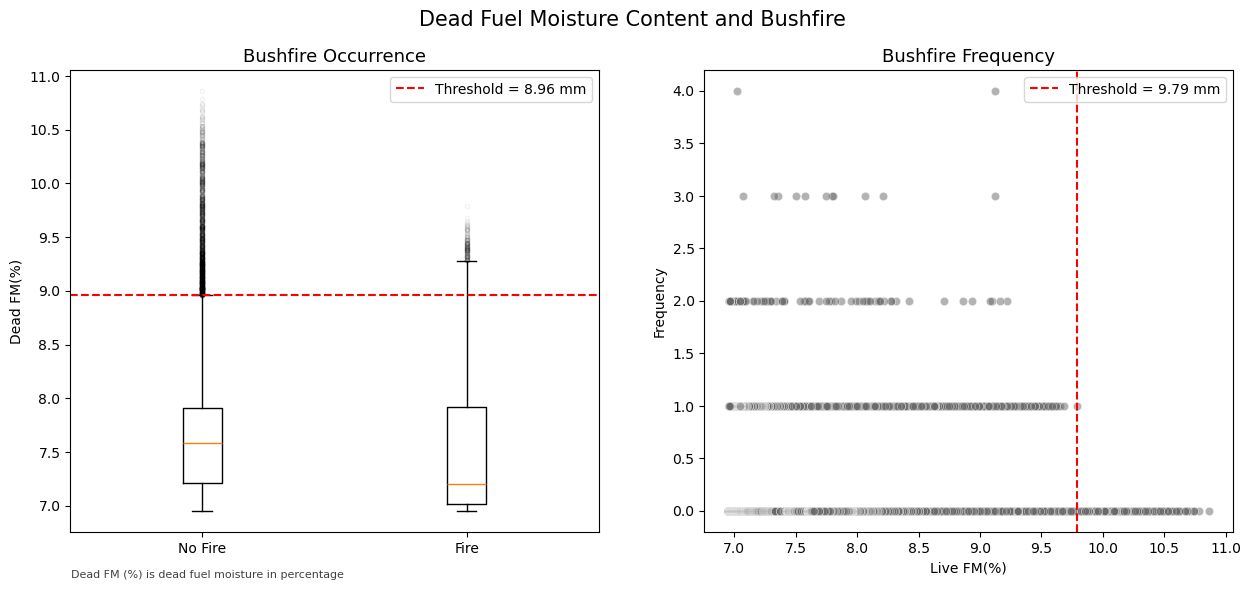

In [69]:
## Dead fuel moisture content - Factor Analysis
## Part 3 - Plotting the results

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plt.suptitle('Dead Fuel Moisture Content and Bushfire', fontsize=15)

## part A ##
## Calculating the threshold of dead fuel moisture content
## that may cause bushfire
## method: find the upper bound of IQR
dead_fmc = pd.Series(no_fire_area).describe()
dead_fmc_25 = dead_fmc['25%']
dead_fmc_75 = dead_fmc['75%']
iqr = dead_fmc_75 - dead_fmc_25
upper_bound_iqr = dead_fmc_75 + 1.5 * iqr

ax[0].boxplot([no_fire_area, fire_area], labels=['No Fire', 'Fire'], flierprops=dict(marker='.', color='lightgrey', alpha=0.05))
ax[0].axhline(upper_bound_iqr, color='r', linestyle='--', label=f'Threshold = {upper_bound_iqr:.2f} mm')
ax[0].set_title('Bushfire Occurrence', fontsize=13)
ax[0].set_ylabel('Dead FM(%)')
ax[0].legend()
## ----- ##

## part B ##
# Find the maximum dead mc at one fire occurrence
threshold = np.max(dead_fm_flat[fire_occ_flat == 1])

ax[1].scatter(dead_fm_flat, fire_occ_flat, alpha=0.5, edgecolors='w', linewidth=0.5, color='dimgrey')
ax[1].axvline(threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f} mm')
ax[1].set_title('Bushfire Frequency', fontsize=13)
ax[1].set_xlabel('Live FM(%)')
ax[1].set_ylabel('Frequency')
ax[1].legend()

print(f'Correlation between live fuel moisture content and fire frequency: {round(dead_fm_cc, 4)}')
ax[0].annotate(f'Dead FM (%) is dead fuel moisture in percentage', xy=(0, 0), xycoords='axes fraction', xytext=(0.26, -0.1), textcoords='axes fraction', horizontalalignment='center', fontsize=8, color='black', alpha=0.75)

# ax[0].annotate(f'Figure 21', xy=(0.5, 0.5), xycoords='axes fraction', 
#             xytext=(0.05, 1.1), textcoords='axes fraction',
#             horizontalalignment='center', fontsize=10, color='black', alpha=0.75)

plt.savefig('Figure21.png', format='png', bbox_inches='tight')

## ----- ##
plt.show()

<div style="background-color:#E0F7FA;padding:10px;border-left:6px solid #00ACC1;margin-bottom:15px;color:#333;">
    <strong>Summary of Dead Fuel Moisture Content and Bushfire:</strong>
    <br>
    The figure explores the relationship between dead fuel moisture (Dead FM) content and bushfire occurrences and frequency.
    <ul>
        <li><strong>Bushfire Occurrence (Left Panel):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The left panel shows a box plot comparing Dead FM percentages between areas with and without fires. The threshold for Dead FM is 8.96%. Areas that experienced fires tend to have lower Dead FM percentages compared to those that did not, indicating that lower moisture content in dead fuel is associated with higher fire occurrence.
        </p >
        
<li><strong>Bushfire Frequency (Right Panel):</strong></li>
        <p style="margin-right:60px; line-height: 1.5;">
        The right panel displays the frequency of bushfires in relation to Dead FM percentages. The threshold for Dead FM is 9.79%. The plot suggests that higher bushfire frequencies are associated with lower Dead FM percentages, reinforcing the observation that lower dead fuel moisture content increases the likelihood of bushfire incidents.
        </p >
    </ul>
    <p style="margin-right:60px; line-height: 1.5;">
    Overall, the analysis highlights the critical role of dead fuel moisture content in bushfire dynamics. Lower Dead FM percentages correlate with both higher occurrences and frequencies of bushfires, emphasizing the importance of monitoring and managing fuel moisture for effective fire risk mitigation.
    </p >
</div>

# 4 Discussion

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Threshold Selection</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        In our analysis, the thresholds were chosen based on quantiles without rigorous calculation. While this method is simple, it may lead to insufficient scientific validity of the results. In the future, more rigorous methods, such as statistical tests or expert knowledge, should be employed to determine appropriate thresholds.
    </p>
    <h4 style="color:#007BFF;">Data Quality and Coverage</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        The study relies on meteorological station data, which has certain limitations, particularly in terms of uneven spatial distribution and data gaps. Future studies should consider using higher resolution satellite data or supplementing with more meteorological station data to improve the accuracy and reliability of the analysis.
    </p>
    <h4 style="color:#007BFF;">Multivariable Analysis</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        The current analysis primarily focuses on the impact of single variables, such as rainfall or temperature. In the future, it is important to consider the interaction of multiple variables, such as combining rainfall, temperature, and fuel moisture content, to conduct a more comprehensive analysis.
    </p>
</div>

# 5 Sustainability

<div style="background-color:#E0F7FA;padding:15px;border-left:6px solid #00ACC1;margin-bottom:20px;color:#333;">
    <h4 style="color:#007BFF;">Climate Change</h4>
    <p style="margin-right:60px; line-height: 1.5;">
        As the planet warms, the frequency and intensity of large-scale bushfires have significantly increased worldwide over the last two decades and are expected to increase further in the coming decades (Abram et al., 2021). The average surface air temperature has increased by 1&deg;C in the past century. Particularly, the south-eastern and south-western regions are experiencing higher temperatures and low rainfall. These conditions contribute to lower soil moisture and higher Forest Fire Danger Index (FFDI) values, increasing the likelihood of large-scale bushfires (Akter & Grafton, 2021). Thus, how the government face climate change becomes a crucial issue in light of this crisis.
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        Australia is the highest per capita carbon emitter among the developed countries. the government actions are under close attentions. Some scholars express concern, the government's hope would be that an enquiry would reduce the pressure for modifying its climate change policies. Such inaction could lead Australia to face recurrent bushfire crises in th future (MaDougall, 2020). They advocate that now is the time to act decisively by repidly reducing greenhouse gas emissions and preparing bushfires for worsening extreme weather events (Steffen et al., 2019). Additionally, the Deputy Governor of the Reserve Bank of Australia noted, the risks that climate change poses to the Australian economy are “first order” (Debelle, 2019).
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        For this reason, the federal government has committed to reducing greenhouse gas emissions by 43% below 2005 levels by 2030 and achieving net zero emissions by 2050. This commitment forms part of Australia's Nationally Determined Contribution (NDC) to the United Nations Framework Convention on Climate Change (UNFCCC), submitted in June 2022. Specific actions include promoting the "green economy" by increasing the share of renewable energy in Australia's electricity grid, increasing the undertake of electric vehicle (EVs) to reduce emissions, encouraging households and communities to install more solar panels. In addition, ready fund to support communities to strengthen their resilience against natural disasters (AOFM, 2024).
    </p>
    <p style="margin-right:60px; line-height: 1.5;">
        Human activities are quietly changing climate patterns, and reversing this trend will require a long time and the efforts of many generations. However, from an optimistic perspective, if we continue to conserve energy and reduce greenhouse gas emissions, adhering to the laws of nature, Ultimately, we will be able to live in harmony with nature.
    </p>
</div>

# 6 References

<div style="background-color:#F0F0F0;padding:15px;border-left:6px solid #A0A0A0;margin-bottom:20px;color:#333;">
    <p>Akter, S., & Grafton, R. Q. (2021). Do fires discriminate? Socio-economic disadvantage, wildfire hazard exposure and the Australian 2019–20 “Black Summer” fires. <em>Climatic Change, 165</em>(3-4). <a href=" ">https://doi.org/10.1007/s10584-021-03064-6</a ></p >

<p>Amoretti, M., Amsler, C., Bonomi, G., Bouchta, A., Bowe, P., Carraro, C., Cesar, C. L., Charlton, M., Collier, M. J. T., Doser, M., Filippini, V., Fine, K. S., Fontana, A., Fujiwara, M. C., Funakoshi, R., Genova, P., Hangst, J. S., Hayano, R. S., Holzscheiter, M. H., & Jørgensen, L. V. (2002). Production and detection of cold antihydrogen atoms. <em>Nature, 419</em>(6906), 456–459. <a href="https://doi.org/10.1038/nature01096">https://doi.org/10.1038/nature01096</a ></p >

<p>Au, C. (2019). <em>Dangerous summer: Escalating bushfire, heat and drought risk</em>. Retrieved from <a href="https://research-management.mq.edu.au/ws/portalfiles/portal/133018559/Publisher_version.pdf">https://research-management.mq.edu.au/ws/portalfiles/portal/133018559/Publisher_version.pdf</a ></p >

<p>Australian Office of Financial Management. (2022). <em>A guide for AGS investors: Australian Government climate change commitments, policies and programs</em>. Retrieved from <a href="https://www.aofm.gov.au/sites/default/files/2022-11-28/Aust%20Govt%20CC%20Actions%20Update%20November%202022_1.pdf">https://www.aofm.gov.au/sites/default/files/2022-11-28/Aust%20Govt%20CC%20Actions%20Update%20November%202022_1.pdf</a ></p >

<p>Deb, P., Moradkhani, H., Abbaszadeh, P., Kiem, A. S., Engström, J., Keellings, D., & Sharma, A. (2020). Causes of the widespread 2019–2020 Australian bushfire season. <em>Earth’s Future, 8</em>(11). <a href="https://doi.org/10.1029/2020ef001671">https://doi.org/10.1029/2020ef001671</a ></p >

<p>McDougall, D. (2020). Australia’s bushfire crisis. <em>The Round Table, 109</em>(1), 94–95. <a href="https://doi.org/10.1080/00358533.2020.1721757">https://doi.org/10.1080/00358533.2020.1721757</a ></p >

<p>Niklas, S., Alexander, D., & Dwyer, S. (2022). Resilient buildings and distributed energy: A grassroots community response to the climate emergency. <em>Sustainability, 14</em>(6), 3186. <a href="https://doi.org/10.3390/su14063186">https://doi.org/10.3390/su14063186</a ></p >

<p>Victorian Curriculum and Assessment Authority. <em>Bushfire education</em>. Retrieved from <a href="https://www.vcaa.vic.edu.au/Documents/viccurric/bushfire/learning/BushfiresinOurHistory.pdf">https://www.vcaa.vic.edu.au/Documents/viccurric/bushfire/learning/BushfiresinOurHistory.pdf</a ></p >
</div>